In [1]:
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from model import *
from utils import *

In [3]:
scdata = pd.read_csv('/home/ehtesamul/sc_st/data/mousedata_2020/E1z2/simu_sc_counts.csv', index_col = 0)
scdata.head(5)

,embryo1_Pos0_cell100_z2,embryo1_Pos0_cell101_z2,embryo1_Pos0_cell102_z2,embryo1_Pos0_cell105_z2,embryo1_Pos0_cell106_z2,embryo1_Pos0_cell107_z2,embryo1_Pos0_cell108_z2,embryo1_Pos0_cell109_z2,embryo1_Pos0_cell11_z2,embryo1_Pos0_cell110_z2,...,embryo1_Pos28_cell9_z2,embryo1_Pos28_cell90_z2,embryo1_Pos28_cell91_z2,embryo1_Pos28_cell92_z2,embryo1_Pos28_cell93_z2,embryo1_Pos28_cell94_z2,embryo1_Pos28_cell95_z2,embryo1_Pos28_cell96_z2,embryo1_Pos28_cell97_z2,embryo1_Pos28_cell98_z2
Abcc4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,2,0,0,0,2
Acp5,2,1,0,2,1,1,0,0,0,0,...,0,0,1,0,2,0,0,1,0,2
Acvr1,0,0,1,0,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
Acvr2a,0,1,0,1,0,0,0,0,1,0,...,3,2,0,0,0,0,2,0,0,2
Adora2b,0,0,1,0,0,0,0,0,1,0,...,2,0,0,0,0,0,0,0,0,0


In [181]:
stdata = pd.read_csv('/home/ehtesamul/sc_st/data/mousedata_2020/E1z2/simu_st_counts.csv', index_col = 0)
stdata.head(5)

,ST_12,ST_13,ST_42,ST_43,ST_49,ST_50,ST_51,ST_52,ST_53,ST_72,...,ST_1158,ST_1159,ST_1179,ST_1180,ST_1181,ST_1182,ST_1183,ST_1184,ST_1185,ST_1186
Abcc4,0.0,0.0,5.0,0.0,1.0,1.0,4.0,1.0,1.0,3.0,...,1.0,0.0,1.0,2.0,0.0,3.0,1.0,2.0,3.0,0.0
Acp5,1.0,1.0,5.0,0.0,5.0,0.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0
Acvr1,0.0,2.0,2.0,0.0,1.0,3.0,5.0,7.0,2.0,1.0,...,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
Acvr2a,2.0,4.0,11.0,0.0,1.0,2.0,1.0,2.0,1.0,3.0,...,2.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0
Adora2b,1.0,2.0,2.0,0.0,0.0,1.0,0.0,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0


In [177]:
scdata = scdata.T
stdata = stdata.T

In [8]:
stgtcelltype = pd.read_csv('/home/ehtesamul/sc_st/data/mousedata_2020/E1z2/simu_st_celltype.csv', index_col = 0)
stgtcelltype.head(5)

,Allantois,Anterior somitic tissues,Blood progenitors,Cardiomyocytes,Cranial mesoderm,Definitive endoderm,Dermomyotome,Endothelium,Erythroid,ExE endoderm,...,Intermediate mesoderm,Lateral plate mesoderm,Mixed mesenchymal mesoderm,NMP,Neural crest,Presomitic mesoderm,Sclerotome,Spinal cord,Splanchnic mesoderm,Surface ectoderm
ST_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ST_13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
ST_42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ST_43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ST_49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [9]:
stgtcelltype.shape

(581, 23)

In [10]:
scdata.head(5)

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0,2,0,0,0,2,0,0,2,0,...,0,0,1,0,0,1,1,0,0,1
embryo1_Pos0_cell101_z2,0,1,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
embryo1_Pos0_cell102_z2,0,0,1,0,1,0,6,6,1,2,...,0,0,0,11,1,1,19,3,1,0
embryo1_Pos0_cell105_z2,0,2,0,1,0,0,0,0,2,0,...,0,0,0,1,1,0,0,0,1,0
embryo1_Pos0_cell106_z2,0,1,1,0,0,0,1,3,2,0,...,0,0,2,5,0,0,2,3,1,0


In [11]:
stdata.head(5)

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
ST_12,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,1.0,...,0.0,1.0,3.0,2.0,1.0,0.0,3.0,3.0,4.0,1.0
ST_13,0.0,1.0,2.0,4.0,2.0,0.0,0.0,4.0,2.0,2.0,...,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,6.0,2.0
ST_42,5.0,5.0,2.0,11.0,2.0,1.0,1.0,11.0,3.0,2.0,...,1.0,0.0,7.0,6.0,1.0,1.0,13.0,8.0,7.0,3.0
ST_43,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0
ST_49,1.0,5.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,...,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0


In [12]:
stdata.shape

(581, 351)

In [13]:
spcoor = pd.read_csv('/home/ehtesamul/sc_st/data/mousedata_2020/E1z2/simu_st_metadata.csv', index_col=0)
spcoor.head(5)

,coord_x,coord_y
ST_12,1581.242732,1329.313864
ST_13,1586.662026,1329.313864
ST_42,1581.242732,1334.863919
ST_43,1586.662026,1334.863919
ST_49,1619.177788,1334.863919


In [14]:
spcoor.shape

(581, 2)

In [15]:
scmetadata = pd.read_csv('/home/ehtesamul/sc_st/data/mousedata_2020/E1z2/metadata.csv', index_col = 0)
scmetadata.head(5)

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors


In [16]:
scmetadata.shape

(10150, 17)

In [17]:
scmetadata.head(5)

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors


In [18]:
adata = sc.AnnData(scdata, obs=scmetadata)
adata

AnnData object with n_obs × n_vars = 10150 × 351
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'

In [19]:
adata.X

array([[0, 2, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 3, 1, 0],
       ...,
       [0, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 3, 0, 0],
       [2, 2, 0, ..., 1, 3, 1]])

In [20]:
adata.var_names

Index(['Abcc4', 'Acp5', 'Acvr1', 'Acvr2a', 'Adora2b', 'Afp', 'Ahnak',
       'Akr1c19', 'Alas2', 'Aldh1a2',
       ...
       'Wnt2b', 'Wnt3', 'Wnt3a', 'Wnt5a', 'Wnt5b', 'Wnt8a', 'Xist', 'Zfp444',
       'Zfp57', 'Zic3'],
      dtype='object', length=351)

In [21]:
adata.obs_names

Index(['embryo1_Pos0_cell100_z2', 'embryo1_Pos0_cell101_z2',
       'embryo1_Pos0_cell102_z2', 'embryo1_Pos0_cell105_z2',
       'embryo1_Pos0_cell106_z2', 'embryo1_Pos0_cell107_z2',
       'embryo1_Pos0_cell108_z2', 'embryo1_Pos0_cell109_z2',
       'embryo1_Pos0_cell11_z2', 'embryo1_Pos0_cell110_z2',
       ...
       'embryo1_Pos28_cell9_z2', 'embryo1_Pos28_cell90_z2',
       'embryo1_Pos28_cell91_z2', 'embryo1_Pos28_cell92_z2',
       'embryo1_Pos28_cell93_z2', 'embryo1_Pos28_cell94_z2',
       'embryo1_Pos28_cell95_z2', 'embryo1_Pos28_cell96_z2',
       'embryo1_Pos28_cell97_z2', 'embryo1_Pos28_cell98_z2'],
      dtype='object', length=10150)

In [22]:
scdata.head(5)

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0,2,0,0,0,2,0,0,2,0,...,0,0,1,0,0,1,1,0,0,1
embryo1_Pos0_cell101_z2,0,1,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
embryo1_Pos0_cell102_z2,0,0,1,0,1,0,6,6,1,2,...,0,0,0,11,1,1,19,3,1,0
embryo1_Pos0_cell105_z2,0,2,0,1,0,0,0,0,2,0,...,0,0,0,1,1,0,0,0,1,0
embryo1_Pos0_cell106_z2,0,1,1,0,0,0,1,3,2,0,...,0,0,2,5,0,0,2,3,1,0


In [23]:
scmetadata

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,embryo1,249,117,embryo1_Pos28_cell94_z2,embryo1,Pos28,2,1547.532898,1518.029214,-1.538991,2.596733,embryo1_Pos28,embryo1_Pos28_2,8160,1.387528,3.173942,Spinal cord
embryo1_Pos28_cell95_z2,embryo1,385,152,embryo1_Pos28_cell95_z2,embryo1,Pos28,2,1547.675803,1528.829589,-1.534381,2.945132,embryo1_Pos28,embryo1_Pos28_2,10032,-1.776725,-1.773125,Anterior somitic tissues
embryo1_Pos28_cell96_z2,embryo1,264,133,embryo1_Pos28_cell96_z2,embryo1,Pos28,2,1547.365765,1535.121229,-1.544382,3.148089,embryo1_Pos28,embryo1_Pos28_2,8368,0.336822,-0.025109,Neural crest
embryo1_Pos28_cell97_z2,embryo1,355,152,embryo1_Pos28_cell97_z2,embryo1,Pos28,2,1547.535748,1520.121983,-1.538899,2.664242,embryo1_Pos28,embryo1_Pos28_2,7552,1.500579,4.424931,Spinal cord


In [24]:
new_scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
new_scdata.head(5)

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0,2,0,0,0,2,0,0,2,0,...,0,0,1,0,0,1,1,0,0,1
embryo1_Pos0_cell101_z2,0,1,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
embryo1_Pos0_cell102_z2,0,0,1,0,1,0,6,6,1,2,...,0,0,0,11,1,1,19,3,1,0
embryo1_Pos0_cell105_z2,0,2,0,1,0,0,0,0,2,0,...,0,0,0,1,1,0,0,0,1,0
embryo1_Pos0_cell106_z2,0,1,1,0,0,0,1,3,2,0,...,0,0,2,5,0,0,2,3,1,0


In [25]:
adata.obs['embryo']

embryo1_Pos0_cell100_z2    embryo1
embryo1_Pos0_cell101_z2    embryo1
embryo1_Pos0_cell102_z2    embryo1
embryo1_Pos0_cell105_z2    embryo1
embryo1_Pos0_cell106_z2    embryo1
                            ...   
embryo1_Pos28_cell94_z2    embryo1
embryo1_Pos28_cell95_z2    embryo1
embryo1_Pos28_cell96_z2    embryo1
embryo1_Pos28_cell97_z2    embryo1
embryo1_Pos28_cell98_z2    embryo1
Name: embryo, Length: 10150, dtype: object

In [26]:
scdata.head(5)

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0,2,0,0,0,2,0,0,2,0,...,0,0,1,0,0,1,1,0,0,1
embryo1_Pos0_cell101_z2,0,1,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
embryo1_Pos0_cell102_z2,0,0,1,0,1,0,6,6,1,2,...,0,0,0,11,1,1,19,3,1,0
embryo1_Pos0_cell105_z2,0,2,0,1,0,0,0,0,2,0,...,0,0,0,1,1,0,0,0,1,0
embryo1_Pos0_cell106_z2,0,1,1,0,0,0,1,3,2,0,...,0,0,2,5,0,0,2,3,1,0


In [27]:
new_scdata.head(5)

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0,2,0,0,0,2,0,0,2,0,...,0,0,1,0,0,1,1,0,0,1
embryo1_Pos0_cell101_z2,0,1,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
embryo1_Pos0_cell102_z2,0,0,1,0,1,0,6,6,1,2,...,0,0,0,11,1,1,19,3,1,0
embryo1_Pos0_cell105_z2,0,2,0,1,0,0,0,0,2,0,...,0,0,0,1,1,0,0,0,1,0
embryo1_Pos0_cell106_z2,0,1,1,0,0,0,1,3,2,0,...,0,0,2,5,0,0,2,3,1,0


In [28]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,embryo1,249,117,embryo1_Pos28_cell94_z2,embryo1,Pos28,2,1547.532898,1518.029214,-1.538991,2.596733,embryo1_Pos28,embryo1_Pos28_2,8160,1.387528,3.173942,Spinal cord
embryo1_Pos28_cell95_z2,embryo1,385,152,embryo1_Pos28_cell95_z2,embryo1,Pos28,2,1547.675803,1528.829589,-1.534381,2.945132,embryo1_Pos28,embryo1_Pos28_2,10032,-1.776725,-1.773125,Anterior somitic tissues
embryo1_Pos28_cell96_z2,embryo1,264,133,embryo1_Pos28_cell96_z2,embryo1,Pos28,2,1547.365765,1535.121229,-1.544382,3.148089,embryo1_Pos28,embryo1_Pos28_2,8368,0.336822,-0.025109,Neural crest
embryo1_Pos28_cell97_z2,embryo1,355,152,embryo1_Pos28_cell97_z2,embryo1,Pos28,2,1547.535748,1520.121983,-1.538899,2.664242,embryo1_Pos28,embryo1_Pos28_2,7552,1.500579,4.424931,Spinal cord


In [179]:
scdata = new_scdata
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X, index = stadata.obs_names, columns = stadata.var_names)

In [180]:
stdata

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
ST_12,0.000000,0.934473,0.000000,1.408971,0.934473,0.934473,0.000000,1.408971,1.408971,0.934473,...,0.000000,0.934473,1.729461,1.408971,0.934473,0.000000,1.729461,1.729461,1.971785,0.934473
ST_13,0.000000,1.160979,1.683825,2.279545,1.683825,0.000000,0.000000,2.279545,1.683825,1.683825,...,0.000000,1.160979,1.160979,1.160979,0.000000,0.000000,2.025404,0.000000,2.650305,1.683825
ST_42,1.306862,1.306862,0.731322,1.935577,0.731322,0.431076,0.431076,1.935577,0.961928,0.731322,...,0.431076,0.000000,1.562847,1.443023,0.431076,0.431076,2.080174,1.669837,1.562847,0.961928
ST_43,0.000000,0.000000,0.000000,0.000000,0.000000,1.112655,2.215904,1.963929,0.000000,0.000000,...,0.000000,1.112655,1.626265,0.000000,0.000000,1.112655,0.000000,1.963929,0.000000,1.112655
ST_49,1.010187,2.275272,1.010187,1.010187,0.000000,1.010187,1.502349,1.502349,2.816308,0.000000,...,0.000000,0.000000,1.010187,1.502349,0.000000,1.010187,1.502349,0.000000,1.010187,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST_1182,1.457023,1.161725,0.000000,0.000000,0.000000,1.161725,0.740851,1.870047,0.000000,1.870047,...,0.000000,0.740851,0.740851,0.000000,1.161725,0.740851,0.000000,1.457023,1.457023,0.000000
ST_1183,0.835602,0.000000,0.000000,0.835602,0.000000,0.000000,0.000000,1.593025,0.000000,1.593025,...,0.000000,0.835602,1.284373,0.000000,0.000000,1.284373,2.732302,2.019029,0.835602,0.000000
ST_1184,1.028667,0.641152,0.000000,0.641152,1.028667,0.641152,0.641152,1.028667,1.028667,3.533706,...,0.000000,0.000000,1.028667,0.641152,0.641152,0.641152,1.524896,1.028667,1.703535,1.307251
ST_1185,1.571756,0.000000,0.820528,0.820528,0.000000,1.571756,1.265086,1.806121,0.000000,3.564898,...,0.820528,1.265086,0.820528,1.265086,0.820528,0.820528,2.155266,1.995855,2.155266,1.265086


In [30]:
adata.obsm['spatial'] = scmetadata[['x_global', 'y_global']].values

In [31]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,embryo1,249,117,embryo1_Pos28_cell94_z2,embryo1,Pos28,2,1547.532898,1518.029214,-1.538991,2.596733,embryo1_Pos28,embryo1_Pos28_2,8160,1.387528,3.173942,Spinal cord
embryo1_Pos28_cell95_z2,embryo1,385,152,embryo1_Pos28_cell95_z2,embryo1,Pos28,2,1547.675803,1528.829589,-1.534381,2.945132,embryo1_Pos28,embryo1_Pos28_2,10032,-1.776725,-1.773125,Anterior somitic tissues
embryo1_Pos28_cell96_z2,embryo1,264,133,embryo1_Pos28_cell96_z2,embryo1,Pos28,2,1547.365765,1535.121229,-1.544382,3.148089,embryo1_Pos28,embryo1_Pos28_2,8368,0.336822,-0.025109,Neural crest
embryo1_Pos28_cell97_z2,embryo1,355,152,embryo1_Pos28_cell97_z2,embryo1,Pos28,2,1547.535748,1520.121983,-1.538899,2.664242,embryo1_Pos28,embryo1_Pos28_2,7552,1.500579,4.424931,Spinal cord


In [32]:
spcoor

,coord_x,coord_y
ST_12,1581.242732,1329.313864
ST_13,1586.662026,1329.313864
ST_42,1581.242732,1334.863919
ST_43,1586.662026,1334.863919
ST_49,1619.177788,1334.863919
...,...,...
ST_1182,1581.242732,1545.766004
ST_1183,1586.662026,1545.766004
ST_1184,1592.081319,1545.766004
ST_1185,1597.500613,1545.766004


In [33]:
adata.obsm['spatial']

array([[1625.0551283 , 1346.26800741],
       [1624.99788853, 1344.50841715],
       [1625.716288  , 1335.71495847],
       ...,
       [1547.36576514, 1535.12122866],
       [1547.53574798, 1520.12198341],
       [1548.30892522, 1518.91970479]])

In [34]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined,n_genes_by_counts,total_counts
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid,80,107
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid,70,106
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube,210,886
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid,68,99
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors,147,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,embryo1,249,117,embryo1_Pos28_cell94_z2,embryo1,Pos28,2,1547.532898,1518.029214,-1.538991,2.596733,embryo1_Pos28,embryo1_Pos28_2,8160,1.387528,3.173942,Spinal cord,117,249
embryo1_Pos28_cell95_z2,embryo1,385,152,embryo1_Pos28_cell95_z2,embryo1,Pos28,2,1547.675803,1528.829589,-1.534381,2.945132,embryo1_Pos28,embryo1_Pos28_2,10032,-1.776725,-1.773125,Anterior somitic tissues,152,385
embryo1_Pos28_cell96_z2,embryo1,264,133,embryo1_Pos28_cell96_z2,embryo1,Pos28,2,1547.365765,1535.121229,-1.544382,3.148089,embryo1_Pos28,embryo1_Pos28_2,8368,0.336822,-0.025109,Neural crest,133,264
embryo1_Pos28_cell97_z2,embryo1,355,152,embryo1_Pos28_cell97_z2,embryo1,Pos28,2,1547.535748,1520.121983,-1.538899,2.664242,embryo1_Pos28,embryo1_Pos28_2,7552,1.500579,4.424931,Spinal cord,152,355


In [35]:
sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)


In [36]:
dp = 1- adata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp

0.5836734693877551

In [37]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0') # device
setattr(opt, 'outf', 'log/test') # folder to save log files
setattr(opt, 'n_genes', 351) # number of genes for the input
setattr(opt, 'no_bn', False) # duplicated
setattr(opt, 'lr', 0.002) # learning rate
setattr(opt, 'sigma', 3)  # the spatial variance parameter in the Gaussian function
setattr(opt, 'alpha', 0.8) # MMD loss weight default:0.8
setattr(opt, 'verbose', True) # verbose
setattr(opt, 'mmdbatch', 1000) # batch for MMD loss
setattr(opt, 'dp', dp) # dropout rate for ST data

In [38]:
opt.device

'cuda:0'

In [39]:
if not os.path.exists(opt.outf):
    os.makedirs(opt.outf)

In [40]:
spcoor

,coord_x,coord_y
ST_12,1581.242732,1329.313864
ST_13,1586.662026,1329.313864
ST_42,1581.242732,1334.863919
ST_43,1586.662026,1334.863919
ST_49,1619.177788,1334.863919
...,...,...
ST_1182,1581.242732,1545.766004
ST_1183,1586.662026,1545.766004
ST_1184,1592.081319,1545.766004
ST_1185,1597.500613,1545.766004


In [41]:
stgtcelltype

,Allantois,Anterior somitic tissues,Blood progenitors,Cardiomyocytes,Cranial mesoderm,Definitive endoderm,Dermomyotome,Endothelium,Erythroid,ExE endoderm,...,Intermediate mesoderm,Lateral plate mesoderm,Mixed mesenchymal mesoderm,NMP,Neural crest,Presomitic mesoderm,Sclerotome,Spinal cord,Splanchnic mesoderm,Surface ectoderm
ST_12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ST_13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
ST_42,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ST_43,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ST_49,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.666667,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST_1182,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.0
ST_1183,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.0
ST_1184,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0
ST_1185,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0


In [42]:
stadata.obs

,n_genes_by_counts,total_counts
ST_12,224,330.587560
ST_13,171,284.537832
ST_42,299,339.288781
ST_43,149,254.029876
ST_49,206,316.809254
...,...,...
ST_1182,254,341.006386
ST_1183,236,341.623526
ST_1184,301,382.682596
ST_1185,239,334.306892


<Figure size 1000x500 with 0 Axes>

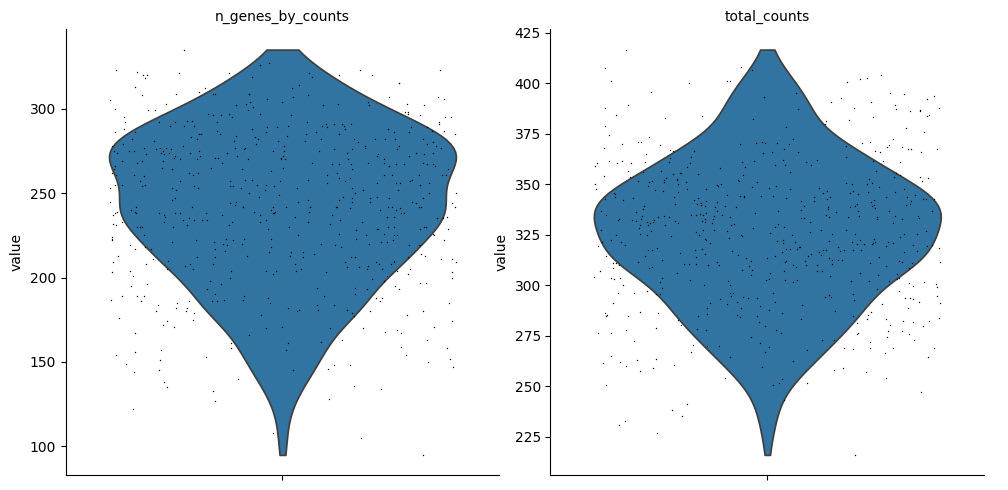

In [43]:
import matplotlib.pyplot as plt
import scanpy as sc

# Set figure size
plt.figure(figsize=(10, 5))

# Create the violin plots
sc.pl.violin(stadata, ['n_genes_by_counts', 'total_counts'], 
             jitter=0.4, multi_panel=True)

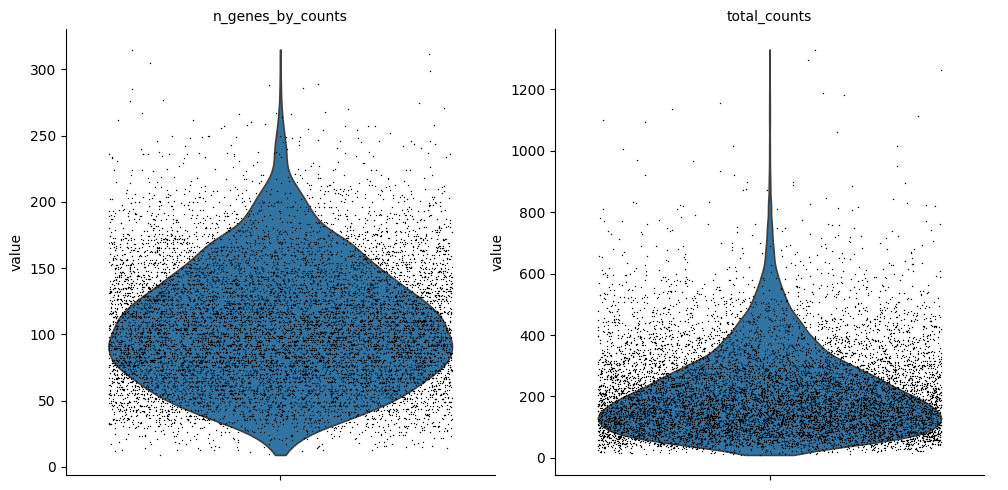

In [44]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

In [45]:
st_neighbor = scipy.spatial.distance.cdist(spcoor, spcoor)
sigma = 3
st_neighbor = np.exp(-st_neighbor ** 2/ (2*sigma**2))/ (np.sqrt(2*np.pi)*sigma)

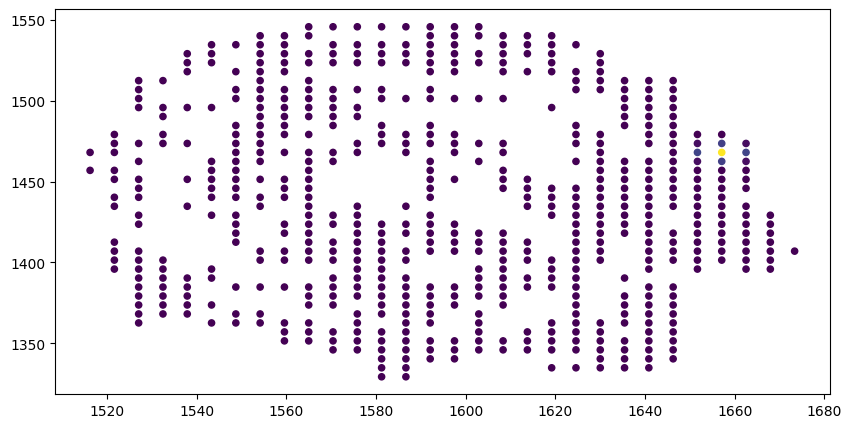

In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(spcoor.values[:, 0], spcoor.values[:, 1], c=np.log1p(st_neighbor[400, :]), s=20)

In [47]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log/Mouse_E1z2')
setattr(opt, 'n_genes', 351)
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 3)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dp)

In [48]:
%%time
testmodel = SOmodel(opt)
testmodel.togpu()
loss_curve = testmodel.train_wholedata(600, torch.tensor(scdata.values).float(), torch.tensor(stdata.values).float(), torch.tensor(spcoor.values).float())

[Train][0] Loss: E 3.622 E_pred 3.580 E_circle 5.264 E_mmd 0.053
[0.002]
[Train][1] Loss: E 4.879 E_pred 4.836 E_circle 5.266 E_mmd 0.054
[0.002]
[Train][2] Loss: E 4.279 E_pred 4.246 E_circle 5.226 E_mmd 0.041
[0.002]
[Train][3] Loss: E 3.500 E_pred 3.461 E_circle 4.826 E_mmd 0.049
[0.002]
[Train][4] Loss: E 3.606 E_pred 3.569 E_circle 4.532 E_mmd 0.045
[0.002]
[Train][5] Loss: E 3.367 E_pred 3.324 E_circle 4.685 E_mmd 0.054
[0.002]
[Train][6] Loss: E 3.555 E_pred 3.509 E_circle 4.743 E_mmd 0.057
[0.002]
[Train][7] Loss: E 3.218 E_pred 3.184 E_circle 4.362 E_mmd 0.044
[0.002]
[Train][8] Loss: E 3.171 E_pred 3.138 E_circle 4.127 E_mmd 0.041
[0.002]
[Train][9] Loss: E 3.099 E_pred 3.071 E_circle 4.072 E_mmd 0.034
[0.002]
[Train][10] Loss: E 3.063 E_pred 3.027 E_circle 4.052 E_mmd 0.046
[0.002]
[Train][11] Loss: E 3.071 E_pred 3.039 E_circle 4.040 E_mmd 0.040
[0.002]
[Train][12] Loss: E 3.036 E_pred 3.005 E_circle 4.013 E_mmd 0.039
[0.002]
[Train][13] Loss: E 2.944 E_pred 2.915 E_circle 

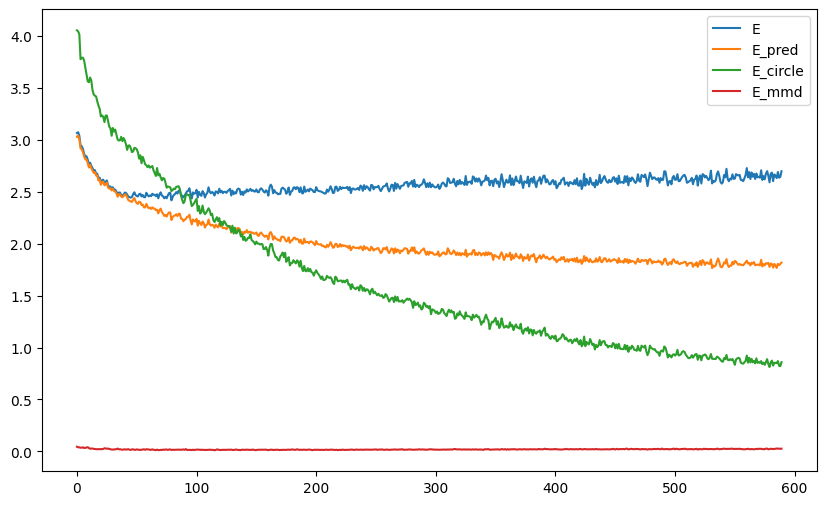

In [49]:
plt.figure(figsize=(10,6))
skip = 10
N = len(loss_curve['E']) - skip
plt.plot(np.arange(N), loss_curve['E'][skip:], label='E')
plt.plot(np.arange(N), loss_curve['E_pred'][skip:], label='E_pred')
plt.plot(np.arange(N), loss_curve['E_circle'][skip:], label='E_circle')
plt.plot(np.arange(N), loss_curve['E_mmd'][skip:], label='E_mmd')
plt.legend()

In [50]:
stdata

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
ST_12,0.000000,0.934473,0.000000,1.408971,0.934473,0.934473,0.000000,1.408971,1.408971,0.934473,...,0.000000,0.934473,1.729461,1.408971,0.934473,0.000000,1.729461,1.729461,1.971785,0.934473
ST_13,0.000000,1.160979,1.683825,2.279545,1.683825,0.000000,0.000000,2.279545,1.683825,1.683825,...,0.000000,1.160979,1.160979,1.160979,0.000000,0.000000,2.025404,0.000000,2.650305,1.683825
ST_42,1.306862,1.306862,0.731322,1.935577,0.731322,0.431076,0.431076,1.935577,0.961928,0.731322,...,0.431076,0.000000,1.562847,1.443023,0.431076,0.431076,2.080174,1.669837,1.562847,0.961928
ST_43,0.000000,0.000000,0.000000,0.000000,0.000000,1.112655,2.215904,1.963929,0.000000,0.000000,...,0.000000,1.112655,1.626265,0.000000,0.000000,1.112655,0.000000,1.963929,0.000000,1.112655
ST_49,1.010187,2.275272,1.010187,1.010187,0.000000,1.010187,1.502349,1.502349,2.816308,0.000000,...,0.000000,0.000000,1.010187,1.502349,0.000000,1.010187,1.502349,0.000000,1.010187,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST_1182,1.457023,1.161725,0.000000,0.000000,0.000000,1.161725,0.740851,1.870047,0.000000,1.870047,...,0.000000,0.740851,0.740851,0.000000,1.161725,0.740851,0.000000,1.457023,1.457023,0.000000
ST_1183,0.835602,0.000000,0.000000,0.835602,0.000000,0.000000,0.000000,1.593025,0.000000,1.593025,...,0.000000,0.835602,1.284373,0.000000,0.000000,1.284373,2.732302,2.019029,0.835602,0.000000
ST_1184,1.028667,0.641152,0.000000,0.641152,1.028667,0.641152,0.641152,1.028667,1.028667,3.533706,...,0.000000,0.000000,1.028667,0.641152,0.641152,0.641152,1.524896,1.028667,1.703535,1.307251
ST_1185,1.571756,0.000000,0.820528,0.820528,0.000000,1.571756,1.265086,1.806121,0.000000,3.564898,...,0.820528,1.265086,0.820528,1.265086,0.820528,0.820528,2.155266,1.995855,2.155266,1.265086


In [51]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values, dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values, dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()), dim=1).detach().cpu().numpy()

In [52]:
netst2sc.shape

(581, 10150)

In [53]:
netsc2st.shape

(10150, 581)

In [54]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
dataset_name = 'E1z2'
result_dir = f'result/{timestamp}_{dataset_name}'
os.makedirs(result_dir, exist_ok=True)

np.save(f'{result_dir}/st2sc_mapping.npy', netst2sc)
np.save(f'{result_dir}/sc2st_mapping.npy', netsc2st)
np.save(f'{result_dir}/sc_embedding.npy', scembedding.detach().cpu().numpy())
np.save(f'{result_dir}/st_embedding.npy', stembedding.detach().cpu().numpy())

In [55]:
testmodel.save()

In [56]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/mappingmtx.values,axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

In [57]:
adata.obsm['SpatialDA'] = all_coord(pd.DataFrame(netsc2st, index=adata.obs_names, columns=stadata.obs_names), spcoor)

In [58]:
adata.obsm['SpatialDA']

array([[1627.08873976, 1349.83280153],
       [1625.6872095 , 1349.33445251],
       [1625.83948815, 1335.58166381],
       ...,
       [1548.33028341, 1534.36304947],
       [1556.69295443, 1523.01574754],
       [1552.97301206, 1518.43547195]])

In [59]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.fonttype'] = 42

# saliency maps


In [60]:
fig_dir = './result_E1z2/'
os.makedirs(fig_dir, exist_ok = True)
sc.settings.figdir = fig_dir


In [61]:
scmetadata

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,embryo1,249,117,embryo1_Pos28_cell94_z2,embryo1,Pos28,2,1547.532898,1518.029214,-1.538991,2.596733,embryo1_Pos28,embryo1_Pos28_2,8160,1.387528,3.173942,Spinal cord
embryo1_Pos28_cell95_z2,embryo1,385,152,embryo1_Pos28_cell95_z2,embryo1,Pos28,2,1547.675803,1528.829589,-1.534381,2.945132,embryo1_Pos28,embryo1_Pos28_2,10032,-1.776725,-1.773125,Anterior somitic tissues
embryo1_Pos28_cell96_z2,embryo1,264,133,embryo1_Pos28_cell96_z2,embryo1,Pos28,2,1547.365765,1535.121229,-1.544382,3.148089,embryo1_Pos28,embryo1_Pos28_2,8368,0.336822,-0.025109,Neural crest
embryo1_Pos28_cell97_z2,embryo1,355,152,embryo1_Pos28_cell97_z2,embryo1,Pos28,2,1547.535748,1520.121983,-1.538899,2.664242,embryo1_Pos28,embryo1_Pos28_2,7552,1.500579,4.424931,Spinal cord


In [62]:
scdata

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0,2,0,0,0,2,0,0,2,0,...,0,0,1,0,0,1,1,0,0,1
embryo1_Pos0_cell101_z2,0,1,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
embryo1_Pos0_cell102_z2,0,0,1,0,1,0,6,6,1,2,...,0,0,0,11,1,1,19,3,1,0
embryo1_Pos0_cell105_z2,0,2,0,1,0,0,0,0,2,0,...,0,0,0,1,1,0,0,0,1,0
embryo1_Pos0_cell106_z2,0,1,1,0,0,0,1,3,2,0,...,0,0,2,5,0,0,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,2,0,0,0,0,0,0,1,0,2,...,0,0,0,0,0,0,0,5,1,0
embryo1_Pos28_cell95_z2,0,0,1,2,0,0,1,2,0,13,...,0,0,0,0,2,0,7,2,2,1
embryo1_Pos28_cell96_z2,0,1,0,0,0,0,0,2,0,3,...,0,0,0,0,1,0,6,1,1,1
embryo1_Pos28_cell97_z2,0,0,0,0,0,0,1,3,1,0,...,0,0,1,1,1,0,2,3,0,0


## Spinalcoord

In [63]:
spinalcoorddata = scdata[(scmetadata['celltype_mapped_refined'] == 'Spinal cord')&(scmetadata.y_global>1410)].copy()
spinalcoorddata = torch.Tensor(spinalcoorddata.values).cuda()

spinalmetadata = scmetadata[scmetadata['celltype_mapped_refined'] == 'Spinal cord']
spinalmetadata = spinalmetadata[spinalmetadata.y_global > 1410]

# spinalmetadata
spinaladata = adata[(scmetadata['celltype_mapped_refined'] == 'Spinal cord')&(scmetadata.y_global>1410),:].copy()

In [64]:
def curve_length(x,y, poly_coeffs):
    x = np.linspace(0, y-x, 100)
    a5, a4, a3, a2, a1, a0 = poly_coeffs
    curve = a5*x**5+a4*x**4 + a3*x**3 + a2*x**2 +a1*x+a0
    return np.sum(np.sqrt(np.sum((curve[:-1] - curve[1:])**2,axis=1)))

In [65]:
spinalspcoor =  spinaladata.obsm['spatial']

poly_coeffs= np.polyfit(spinalspcoor[:,0],spinalspcoor[:,1],5)
a5, a4, a3, a2, a1, a0 = poly_coeffs
fity = a5*spinalspcoor[:,0]**5 + a4*spinalspcoor[:,0]**4 + a3*spinalspcoor[:,0]**3 + a2*spinalspcoor[:,0]**2 + a1*spinalspcoor[:,0] + a0

pseudotime = []
for i in range(spinalspcoor.shape[0]):
    pseudotime.append(curve_length(spinalspcoor[0,:],spinalspcoor[i,:], poly_coeffs))

pseudotime = np.array(pseudotime)/1e8
pseudotime = (pseudotime.max() - pseudotime)/(pseudotime.max()-pseudotime.min())
spinaladata.obs['pseudotime'] = pseudotime
spinaladata.obsm['pseudotime'] = np.expand_dims(np.array(pseudotime),1)


In [66]:
pseudotime

array([1.        , 0.98194536, 0.98864249, ..., 0.12710995, 0.12140286,
       0.12944594])

In [67]:
spinaladata.obs

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined,n_genes_by_counts,total_counts,pseudotime
embryo1_Pos7_cell112_z2,embryo1,309,143,embryo1_Pos7_cell112_z2,embryo1,Pos7,2,1652.375684,1419.929670,1.843034,-0.567768,embryo1_Pos7,embryo1_Pos7_2,11040,1.619353,3.082072,Spinal cord,143,309,1.000000
embryo1_Pos7_cell115_z2,embryo1,139,84,embryo1_Pos7_cell115_z2,embryo1,Pos7,2,1652.380407,1416.878680,1.843187,-0.666187,embryo1_Pos7,embryo1_Pos7_2,4432,1.370074,4.349392,Spinal cord,84,139,0.981945
embryo1_Pos7_cell126_z2,embryo1,229,122,embryo1_Pos7_cell126_z2,embryo1,Pos7,2,1653.514598,1418.377561,1.879773,-0.617836,embryo1_Pos7,embryo1_Pos7_2,10016,1.416386,3.661189,Spinal cord,122,229,0.988642
embryo1_Pos7_cell130_z2,embryo1,173,91,embryo1_Pos7_cell130_z2,embryo1,Pos7,2,1653.760309,1417.279217,1.887700,-0.653267,embryo1_Pos7,embryo1_Pos7_2,8080,1.421279,3.165911,Spinal cord,91,173,0.982332
embryo1_Pos7_cell132_z2,embryo1,123,72,embryo1_Pos7_cell132_z2,embryo1,Pos7,2,1653.462958,1419.705301,1.878108,-0.575006,embryo1_Pos7,embryo1_Pos7_2,5216,0.950702,3.734206,Spinal cord,72,123,0.993464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell82_z2,embryo1,262,132,embryo1_Pos28_cell82_z2,embryo1,Pos28,2,1546.216556,1517.691610,-1.581454,2.585843,embryo1_Pos28,embryo1_Pos28_2,5552,0.833016,2.676300,Spinal cord,132,262,0.119862
embryo1_Pos28_cell86_z2,embryo1,158,99,embryo1_Pos28_cell86_z2,embryo1,Pos28,2,1546.339618,1518.834702,-1.577484,2.622717,embryo1_Pos28,embryo1_Pos28_2,4240,0.951704,3.790162,Spinal cord,99,158,0.117535
embryo1_Pos28_cell94_z2,embryo1,249,117,embryo1_Pos28_cell94_z2,embryo1,Pos28,2,1547.532898,1518.029214,-1.538991,2.596733,embryo1_Pos28,embryo1_Pos28_2,8160,1.387528,3.173942,Spinal cord,117,249,0.127110
embryo1_Pos28_cell97_z2,embryo1,355,152,embryo1_Pos28_cell97_z2,embryo1,Pos28,2,1547.535748,1520.121983,-1.538899,2.664242,embryo1_Pos28,embryo1_Pos28_2,7552,1.500579,4.424931,Spinal cord,152,355,0.121403


In [68]:
spinaladata.obsm['spatial']

array([[1652.3756843 , 1419.92966981],
       [1652.38040723, 1416.87867974],
       [1653.51459774, 1418.37756075],
       ...,
       [1547.53289771, 1518.02921358],
       [1547.53574798, 1520.12198341],
       [1548.30892522, 1518.91970479]])

/tmp/ipykernel_4086157/2689292356.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spinaladata, color='pseudotime', spot_size=2, basis='spatial')


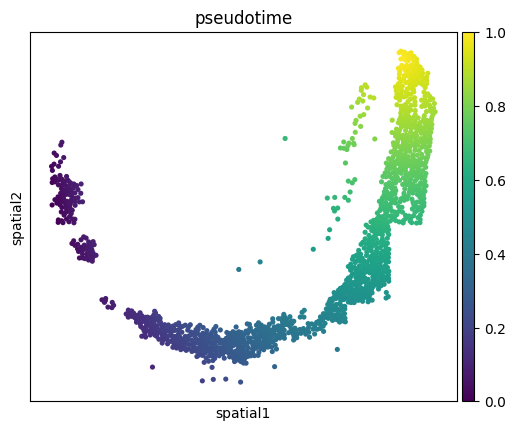

In [69]:
sc.pl.spatial(spinaladata, color='pseudotime', spot_size=2, basis='spatial')

In [70]:
sc.pp.neighbors(spinaladata, use_rep = 'pseudotime')
sc.tl.leiden(spinaladata, resolution=0.1)

/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_4086157/2673987586.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(spinaladata, resolution=0.1)


In [71]:
spinaladata

AnnData object with n_obs × n_vars = 1416 × 351
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_genes_by_counts', 'total_counts', 'pseudotime', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'leiden'
    obsm: 'spatial', 'SpatialDA', 'pseudotime'
    obsp: 'distances', 'connectivities'

In [72]:
spinaladata.obsp['distances']

<1416x1416 sparse matrix of type '<class 'numpy.float64'>'
	with 19824 stored elements in Compressed Sparse Row format>

/tmp/ipykernel_4086157/1205002765.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spinaladata, color='leiden', spot_size=2, save='segments')


<Figure size 1000x600 with 0 Axes>

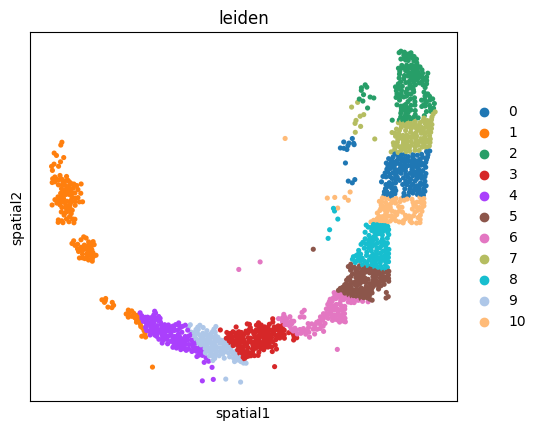

In [73]:
plt.figure(figsize=(10,6))
sc.pl.spatial(spinaladata, color='leiden', spot_size=2, save='segments')

In [74]:
class Captummodel(nn.Module):
    def __init__(self, netE, stembedding):
        super(Captummodel, self).__init__()
        
        self.netE = netE
        self.netE.eval()
        self.stembedding = stembedding.t()

    def forward(self, x):
        x = self.netE(x)
        return x.mm(self.stembedding)    

from captum.attr import IntegratedGradients

In [75]:
# spinalcoorddata.shape
testmodel

SOmodel(
  (netE): FeatureNet(
    (fc1): Linear(in_features=351, out_features=512, bias=True)
    (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (bn2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (dp): Dropout(p=0.5836734693877551, inplace=False)
  )
  (mmd_fn): MMDLoss()
)

In [76]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE, stembedding.detach())
capt.eval()
capt

Captummodel(
  (netE): FeatureNet(
    (fc1): Linear(in_features=351, out_features=512, bias=True)
    (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (bn2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (dp): Dropout(p=0.5836734693877551, inplace=False)
  )
)

In [77]:
inputdata = spinalcoorddata[i].unsqueeze(0)
inputdata

tensor([[ 2.,  2.,  0.,  2.,  0.,  1.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,
          2.,  1.,  0.,  0.,  1.,  1.,  0.,  3.,  0.,  0.,  3.,  1.,  0.,  0.,
          2.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  2.,  0.,
          0.,  5.,  0.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  1.,  1.,  2.,  0.,
          1.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  5.,  1., 21.,  0.,
          0.,  3.,  1.,  0.,  2.,  3.,  5.,  1.,  0.,  0.,  0.,  0.,  1.,  4.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  7.,  1.,  0.,  1.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3., 15.,  0.,
          0.,  0.,  1.,  0.,  2.,  0.,  0.,  4.,  1.,  4.,  0.,  2.,  0.,  0.,
          0.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  3.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  8.,  9.,  9., 10.,  3.,  1.,  0.,  1.,  0., 15.,  0.,  0.,
          0.,  0.,  0.,  0.,  5.,  2.,  0.,  0.,  3.

In [78]:
allsali = []
allbestidx = []
alldelta = []
allscemb = []

for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allscemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions, delta = ig.attribute(inputdata, target=idx, return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())

allsali = np.array(allsali)

100%|██████████| 1416/1416 [00:10<00:00, 132.58it/s]


In [79]:
i = 987
inputdata = spinalcoorddata[i].unsqueeze(0)
scembedding = testmodel.netE(inputdata)
allscemb.append(scembedding.detach().cpu().numpy())
spinal2st = scembedding.mm(stembedding.detach().t())
idx = spinal2st.argmax()
ig = IntegratedGradients(capt)
attributions, delta = ig.attribute(inputdata, target=idx, return_convergence_delta=True)

In [80]:
delta

tensor([0.6282], device='cuda:0', dtype=torch.float64)

In [81]:
saliadata = sc.AnnData(pd.DataFrame(allsali, columns=scdata.columns, index=spinaladata.obs_names), obs=spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['SpatialDA']
                       

In [82]:
allsali.shape

(1416, 351)

In [83]:
sc.tl.rank_genes_groups(saliadata, groupby='leiden', method='wilcoxon')

/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py

In [84]:
saliadata

AnnData object with n_obs × n_vars = 1416 × 351
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_genes_by_counts', 'total_counts', 'pseudotime', 'leiden'
    uns: 'rank_genes_groups'
    obsm: 'spatial', 'spatialDA'

In [85]:
sc.get.rank_genes_groups_df(saliadata, pval_cutoff=0.05, log2fc_min=0, group=None).names.unique().shape

(229,)

In [86]:
saliadata.uns['rank_genes_groups']

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Dusp6', 'Bak1', 'Lin28a', 'Sfrp1', 'Nr2f1', 'Hoxd4', 'Fgfr1', 'Hoxb1', 'Pcdh19', 'Kmt2b', 'Podxl'),
            ('Dnmt3a', 'Meis2', 'Hoxb1', 'Lfng', 'Hoxb4', 'Smim1', 'Hoxb4', 'Cdh2', 'Hoxd4', 'Hoxb8', 'Tcf7l1'),
            ('Hoxc8', 'Pcgf2', 'Icam2', 'Kmt2b', 'Hoxb8', 'Notch1', 'Hoxa7', 'Dnmt3b', 'Notch1', 'Notch1', 'Snai1'),
            ('Podxl', 'Akr1c19', 'Lef1', 'Fzd2', 'Hoxb6', 'Sox2', 'Apoa4', 'Pdgfra', 'Lef1', 'Cntfr', 'Hoxc8'),
            ('Gpc4', 'Pcgf3', 'Ash2l', 'Tead2', 'Eed', 'Pcdh19', 'Hoxb9', 'Lef1', 'Sox4', 'Fzd2', 'Ep300'),
            ('Myh9', 'Kmt2d', 'Setd1b', 'Fgfr3', 'Marcks', 'Hoxb9', 'Hoxd4', 'Acvr1', 'Aqp8', 'Hoxb3', 'Adora2b'),
            ('Gata4', 'Nefl', 'Tal1', 'Hoxa7', 'Col4a1', 'Hoxc6', 'Xist', 'Suz12', 'Zfp444', 'Col4a1', 'Gpc4'),
            ('Ramp2', 'Tjp2', 'Ahnak', 'Col

In [87]:
maxclt = saliadata.obs['leiden'].values.astype(int).max()
clusteridx = []
for i in range(maxclt+1):
    clusteridx.append(saliadata.obs.loc[saliadata.obs['leiden'] == str(i), 'pseudotime'].mean())

a = np.arange(maxclt+1)
reclusterindex = [a for _, a in sorted(zip(clusteridx, a))]


In [88]:
import seaborn as sns
rkgene = pd.DataFrame(saliadata.uns['rank_genes_groups']['names'])
cellorder = saliadata.obs.sort_values('pseudotime').index
salidf = pd.DataFrame(saliadata[cellorder, :].X, index=saliadata[cellorder,:].obs.pseudotime.tolist(), columns=saliadata.var_names)

In [89]:
N = 4
topgenelist = []
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N, i].tolist()

sal_plotgenelist = []
for x in topgenelist:
    if x not in sal_plotgenelist:
        sal_plotgenelist.append(x)

df = salidf.loc[:, sal_plotgenelist].T

In [90]:
salidf.loc[:, sal_plotgenelist]

,Bak1,Meis2,Pcgf2,Akr1c19,Nr2f1,Hoxb4,Hoxb8,Hoxb6,Kmt2b,Notch1,...,Snai1,Hoxc8,Dusp6,Dnmt3a,Hoxb1,Cdh2,Dnmt3b,Pdgfra,Lin28a,Icam2
0.000000,0.539876,0.316412,0.000000,0.000000,-1.537664,-0.120867,-0.000000,1.154982,0.139749,-0.355787,...,-0.000000,0.000000,-0.000000,0.187874,0.000000,-0.597662,0.000000,-0.000000,-3.508558,0.000000
0.006629,1.115354,-0.000154,1.954555,4.869721,-0.860406,0.000000,-0.000000,0.985263,0.087239,-0.000000,...,-0.233361,0.000000,-0.000000,0.152282,0.000000,-0.000000,0.759020,-0.000000,-6.703031,0.909733
0.008893,0.000000,1.780779,2.032731,4.814387,-0.866474,0.880159,-0.000000,0.000000,0.000000,-0.000000,...,-0.000000,0.000000,-0.000000,0.118895,-0.000000,-0.324842,0.000000,-0.000000,-6.067252,0.000000
0.011949,0.000000,0.870093,2.411922,0.977543,-0.511130,1.590103,-0.000000,0.000000,0.013538,0.784958,...,-0.000000,0.000000,-0.000000,0.202022,0.000000,-0.369575,1.311848,-0.000000,-5.154763,0.000000
0.013642,0.877944,-0.077168,1.092658,1.570497,-1.868179,-1.108431,-0.000000,0.000000,0.162312,0.030604,...,-0.000000,0.161876,-0.000000,-0.477873,-0.000000,-0.071236,0.000000,-0.000000,-5.957255,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.988284,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,1.259592,1.771871,0.000000,-0.000000,...,0.000000,0.000000,-0.000000,-0.000000,3.543632,-0.696094,-0.000000,-0.000000,0.184782,0.000000
0.988642,0.000000,0.217873,3.257455,0.000000,0.000000,-1.123107,0.496234,-0.000000,0.329454,-0.000000,...,0.000000,0.415155,0.000000,0.000000,-0.310896,-0.000000,-0.000000,-0.206184,7.694867,0.021847
0.988770,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.510418,-0.794560,...,-0.000000,1.969084,-0.000000,-0.983402,-0.000000,-1.535551,0.000000,-0.000000,-0.540195,0.000000
0.993464,-0.000000,-0.351770,1.324383,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.088081,-0.000000,...,-0.000000,1.175147,0.315127,-0.000000,0.541073,-0.672822,0.950507,-0.000000,2.795743,0.000000


In [91]:
plotsali = saliadata[cellorder,:].copy()
sc.pp.scale(plotsali)

In [92]:
plotsali

AnnData object with n_obs × n_vars = 1416 × 351
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_genes_by_counts', 'total_counts', 'pseudotime', 'leiden'
    var: 'mean', 'std'
    uns: 'rank_genes_groups'
    obsm: 'spatial', 'spatialDA'

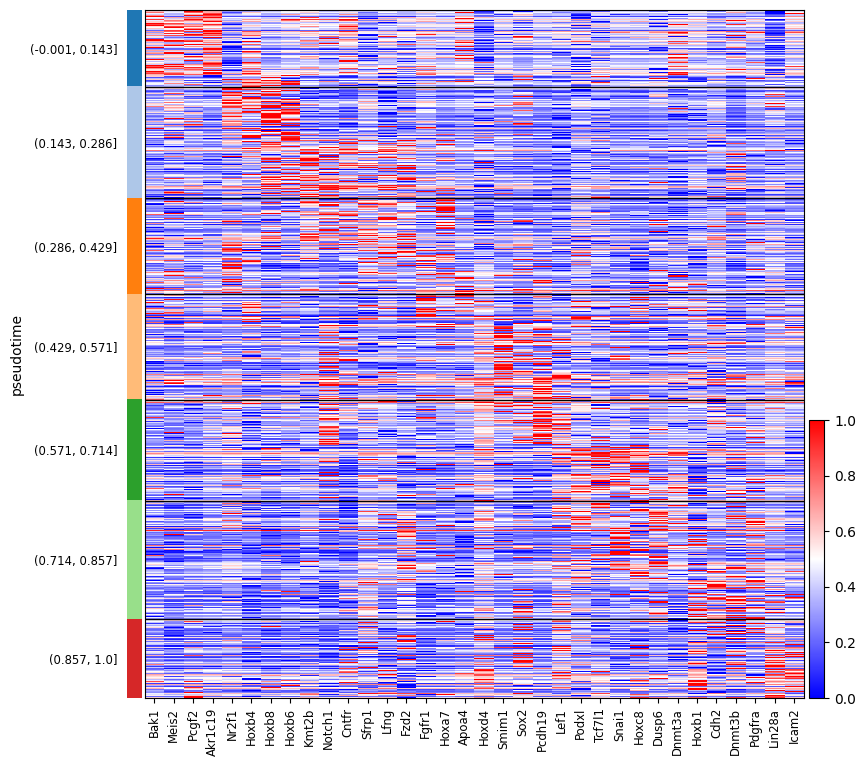

In [93]:
sc.pl.heatmap(plotsali, df.index.tolist(), groupby='pseudotime', cmap='bwr', swap_axes=False, standard_scale='obs', figsize=(9,9), save='spinal_traj_axis.pdf')

In [94]:
spinaladata.obs['pseudotime']

embryo1_Pos7_cell112_z2    1.000000
embryo1_Pos7_cell115_z2    0.981945
embryo1_Pos7_cell126_z2    0.988642
embryo1_Pos7_cell130_z2    0.982332
embryo1_Pos7_cell132_z2    0.993464
                             ...   
embryo1_Pos28_cell82_z2    0.119862
embryo1_Pos28_cell86_z2    0.117535
embryo1_Pos28_cell94_z2    0.127110
embryo1_Pos28_cell97_z2    0.121403
embryo1_Pos28_cell98_z2    0.129446
Name: pseudotime, Length: 1416, dtype: float64

In [95]:
X = pd.DataFrame(spinaladata.X, index=spinaladata.obs_names, columns=spinaladata.var_names)
pseudotime = spinaladata.obs['pseudotime']

bins = pd.qcut(pseudotime, 6, labels=False)
rep_genes = []

for bin_idx in range(6):
    bin_cells = bins == bin_idx
    mean_expr = X.loc[bin_cells].mean()
    # print(mean_expr.shape)
    specificity = mean_expr / (X.mean() + 0.1)
    rep_genes.append(specificity.idxmax())
    print(rep_genes)

['Dll3']
['Dll3', 'Sfrp1']
['Dll3', 'Sfrp1', 'Sox10']
['Dll3', 'Sfrp1', 'Sox10', 'Pcdh19']
['Dll3', 'Sfrp1', 'Sox10', 'Pcdh19', 'Msx1']
['Dll3', 'Sfrp1', 'Sox10', 'Pcdh19', 'Msx1', 'Mesp2']


In [96]:
X = pd.DataFrame(spinaladata.X, index=spinaladata.obs_names, columns=spinaladata.var_names)
pseudotime = spinaladata.obs['pseudotime']

corr_with_pt = []
for gene in X.columns:
    corr = np.abs(np.corrcoef(X[gene], pseudotime)[0,1])
    corr_with_pt.append((gene, corr))
    # print(corr_with_pt)

top_genes = sorted(corr_with_pt, key=lambda x: x[1], reverse=True)[:6]
top_gene_names = [gene for gene, corr in top_genes]
print(top_gene_names)

['Hoxb9', 'Hoxb1', 'Marcks', 'Nr2f1', 'Fgfr3', 'Dll3']


In [97]:
bin_cells

embryo1_Pos7_cell112_z2     True
embryo1_Pos7_cell115_z2     True
embryo1_Pos7_cell126_z2     True
embryo1_Pos7_cell130_z2     True
embryo1_Pos7_cell132_z2     True
                           ...  
embryo1_Pos28_cell82_z2    False
embryo1_Pos28_cell86_z2    False
embryo1_Pos28_cell94_z2    False
embryo1_Pos28_cell97_z2    False
embryo1_Pos28_cell98_z2    False
Name: pseudotime, Length: 1416, dtype: bool

/tmp/ipykernel_4086157/2559012465.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spinaladata, spot_size=3, color = ['Mesp2', 'Hoxb1', 'En1', 'Lin28a', 'Hoxc6', 'Gbx2'], ncols=6, basis='spatial', save = 'traj_expression.pdf')


<Figure size 1000x500 with 0 Axes>

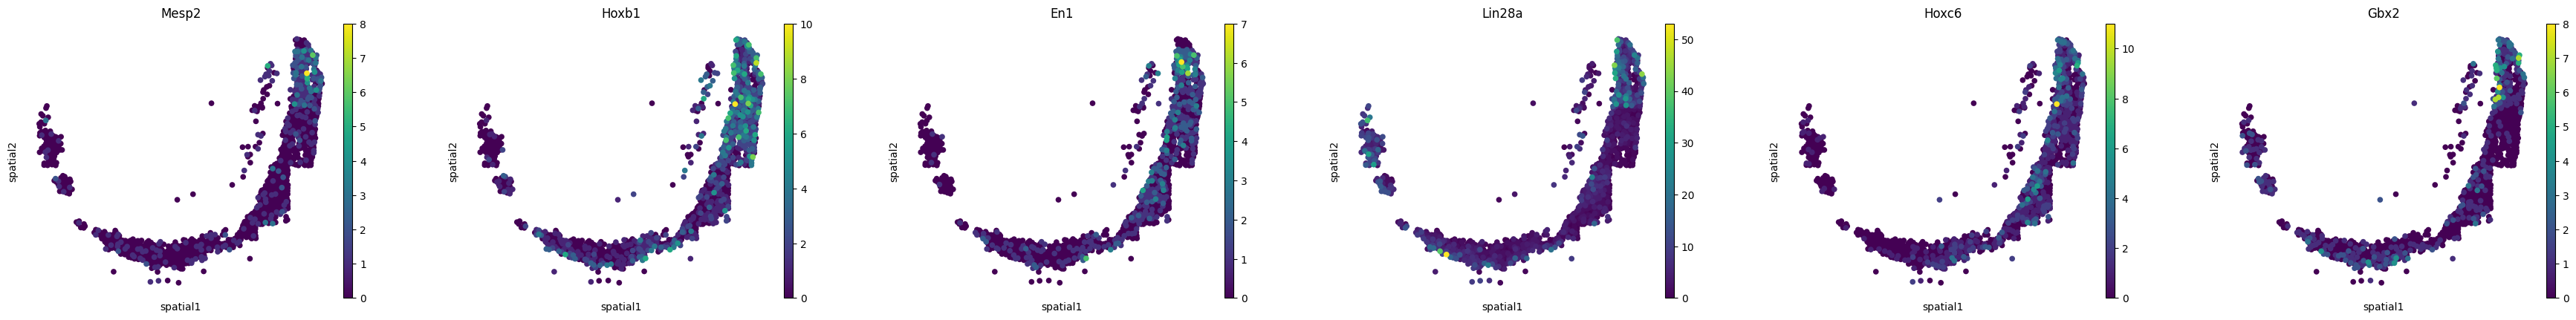

In [98]:
import matplotlib.colors as colors
plt.figure(figsize=(10, 5))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.spatial(spinaladata, spot_size=3, color = ['Mesp2', 'Hoxb1', 'En1', 'Lin28a', 'Hoxc6', 'Gbx2'], ncols=6, basis='spatial', save = 'traj_expression.pdf')

/tmp/ipykernel_4086157/4203578459.py:4: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spinaladata,spot_size=3,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',save='nonspatialsdg.pdf')


<Figure size 1000x500 with 0 Axes>

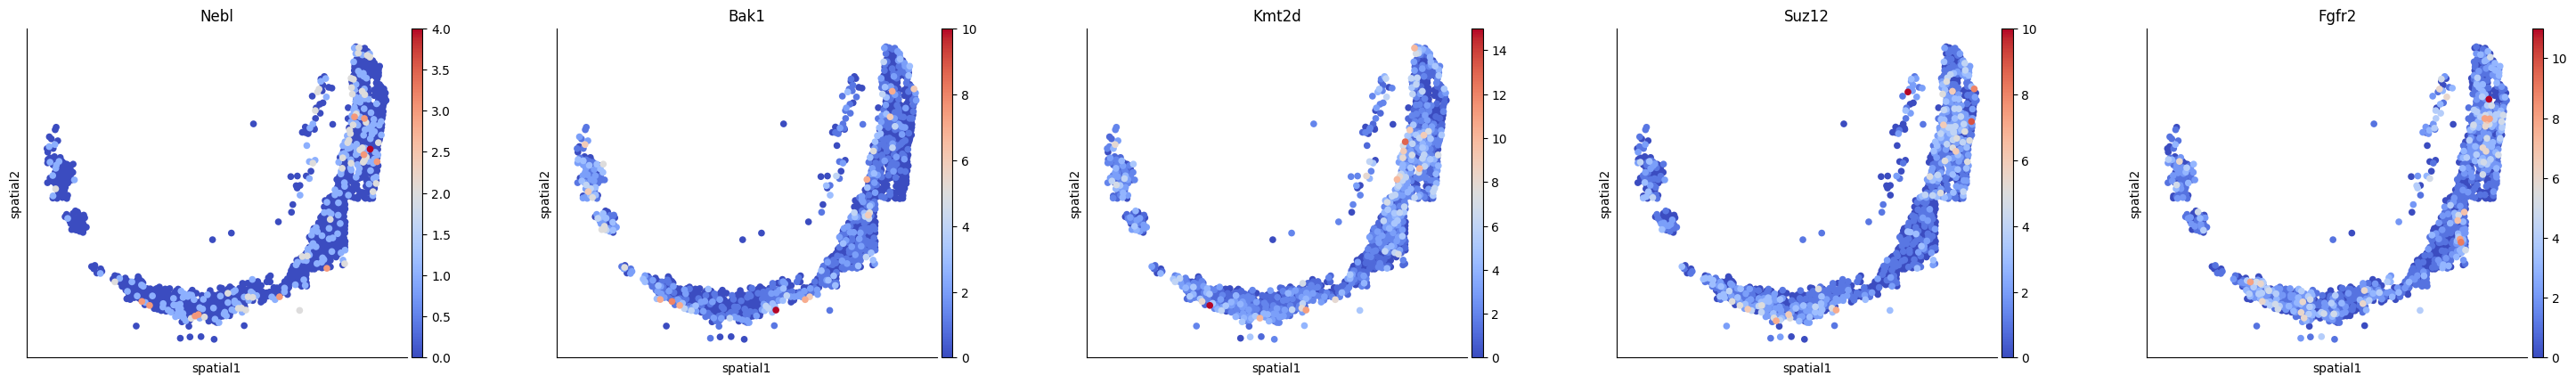

/tmp/ipykernel_4086157/4203578459.py:5: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(saliadata,spot_size=2,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',norm = colors.SymLogNorm(linthresh=0.001,base=10),save='nonspatialsdg-saliency.pdf')


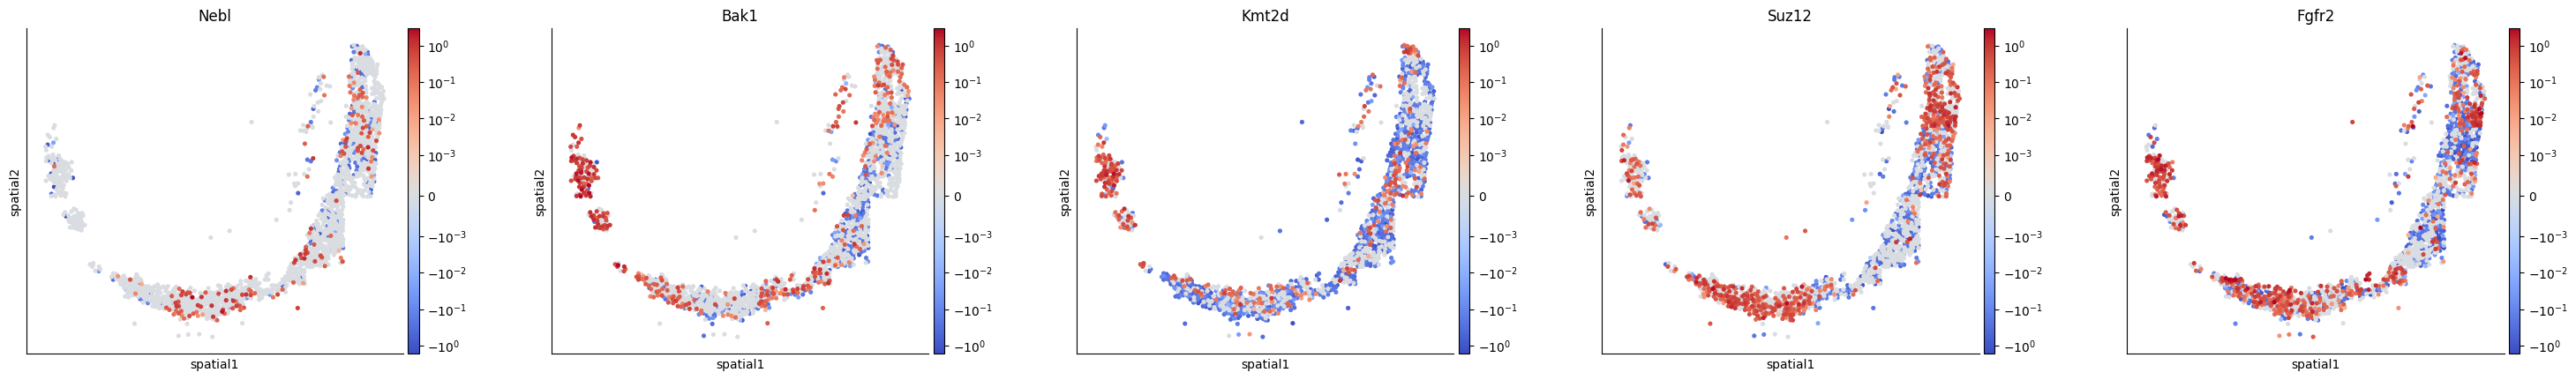

In [99]:
plt.figure(figsize=(10, 5))
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
sc.pl.spatial(spinaladata,spot_size=3,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',save='nonspatialsdg.pdf')
sc.pl.spatial(saliadata,spot_size=2,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',norm = colors.SymLogNorm(linthresh=0.001,base=10),save='nonspatialsdg-saliency.pdf')

# Forebrain/midbrain/hindbrain

In [100]:
scmetadata

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,y_global_affine,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined
embryo1_Pos0_cell100_z2,embryo1,107,80,embryo1_Pos0_cell100_z2,embryo1,Pos0,2,1625.055128,1346.268007,0.961726,-2.943951,embryo1_Pos0,embryo1_Pos0_2,8144,-6.462337,-1.034258,Erythroid
embryo1_Pos0_cell101_z2,embryo1,106,70,embryo1_Pos0_cell101_z2,embryo1,Pos0,2,1624.997889,1344.508417,0.959880,-3.000712,embryo1_Pos0,embryo1_Pos0_2,8560,-6.810907,-0.845417,Erythroid
embryo1_Pos0_cell102_z2,embryo1,886,210,embryo1_Pos0_cell102_z2,embryo1,Pos0,2,1625.716288,1335.714958,0.983054,-3.284372,embryo1_Pos0,embryo1_Pos0_2,15936,4.067604,0.122410,Gut tube
embryo1_Pos0_cell105_z2,embryo1,99,68,embryo1_Pos0_cell105_z2,embryo1,Pos0,2,1625.282523,1349.823455,0.969061,-2.829259,embryo1_Pos0,embryo1_Pos0_2,6768,-6.670613,-0.926943,Erythroid
embryo1_Pos0_cell106_z2,embryo1,267,147,embryo1_Pos0_cell106_z2,embryo1,Pos0,2,1625.242317,1352.717525,0.967764,-2.735902,embryo1_Pos0,embryo1_Pos0_2,7776,-3.569233,-3.798838,Haematoendothelial progenitors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,embryo1,249,117,embryo1_Pos28_cell94_z2,embryo1,Pos28,2,1547.532898,1518.029214,-1.538991,2.596733,embryo1_Pos28,embryo1_Pos28_2,8160,1.387528,3.173942,Spinal cord
embryo1_Pos28_cell95_z2,embryo1,385,152,embryo1_Pos28_cell95_z2,embryo1,Pos28,2,1547.675803,1528.829589,-1.534381,2.945132,embryo1_Pos28,embryo1_Pos28_2,10032,-1.776725,-1.773125,Anterior somitic tissues
embryo1_Pos28_cell96_z2,embryo1,264,133,embryo1_Pos28_cell96_z2,embryo1,Pos28,2,1547.365765,1535.121229,-1.544382,3.148089,embryo1_Pos28,embryo1_Pos28_2,8368,0.336822,-0.025109,Neural crest
embryo1_Pos28_cell97_z2,embryo1,355,152,embryo1_Pos28_cell97_z2,embryo1,Pos28,2,1547.535748,1520.121983,-1.538899,2.664242,embryo1_Pos28,embryo1_Pos28_2,7552,1.500579,4.424931,Spinal cord


In [101]:
spinaladata = adata[scmetadata['celltype_mapped_refined'] == 'Forebrain/Midbrain/Hindbrain', :].copy()
spinaladata = spinaladata[spinaladata.obs['y_global'] < 1430].copy()
spinaladata = spinaladata[spinaladata.obs['x_global'] < 1630].copy()

spinaladata



AnnData object with n_obs × n_vars = 1703 × 351
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial', 'SpatialDA'

/tmp/ipykernel_4086157/3449095044.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spinaladata, color='leiden', spot_size=2, basis='spatial')


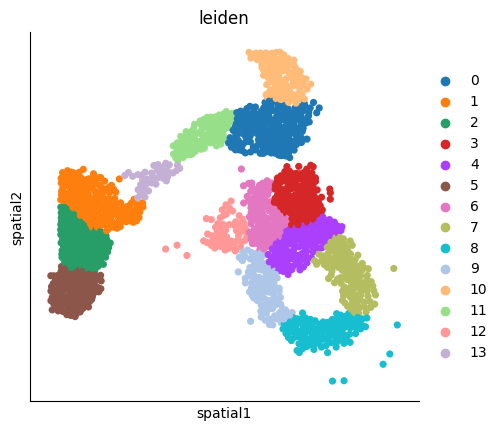

In [102]:
sc.pp.neighbors(spinaladata, use_rep = 'spatial')
sc.tl.leiden(spinaladata, resolution=0.5)
sc.pl.spatial(spinaladata, color='leiden', spot_size=2, basis='spatial')

/tmp/ipykernel_4086157/1898271012.py:18: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spinaladata, color='name', spot_size=2, basis='spatial', save='embryo_brainsep')


<Figure size 600x600 with 0 Axes>

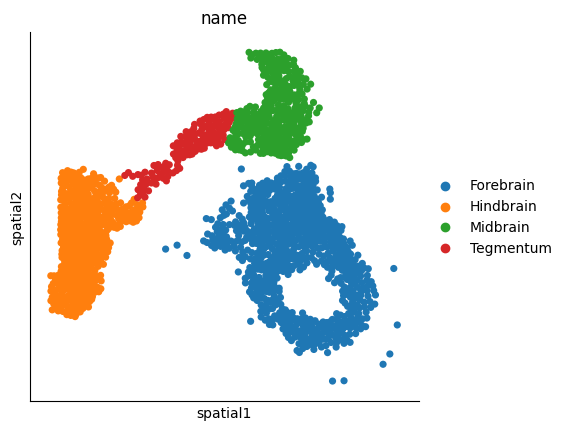

In [103]:
spinaladata.obs['name'] = spinaladata.obs['leiden'].copy().astype(str)
spinaladata.obs.loc[spinaladata.obs['leiden']=='0','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='10','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='2','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='3','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='4','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='5','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='6','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='7','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='8','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='11','name'] ='Tegmentum'
spinaladata.obs.loc[spinaladata.obs['leiden']=='13','name'] ='Tegmentum'
spinaladata.obs.loc[spinaladata.obs['leiden']=='1','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='12','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='9','name'] ='Forebrain'

plt.figure(figsize=(6,6))
sc.pl.spatial(spinaladata, color='name', spot_size=2, basis='spatial', save='embryo_brainsep')

In [183]:
adata.obsm

AxisArrays with keys: 

# TRYING WITH CONDITIONAL DDPM BISMILLAH

In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
import os

class TimeEmbedding(nn.Module):
    """Time embedding for diffusion timesteps"""
    def __init__(self, embedding_dim):
        super(TimeEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.linear1 = nn.Linear(1, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim)
        self.act = nn.SiLU()
        
    def forward(self, t):
        # t: [batch_size, 1]
        t_emb = self.act(self.linear1(t))
        t_emb = self.linear2(t_emb)
        return t_emb

class FeatureEmbedding(nn.Module):
    """Feature embedding for gene expression data"""
    def __init__(self, input_dim, embedding_dim):
        super(FeatureEmbedding, self).__init__()
        self.linear1 = nn.Linear(input_dim, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim)
        self.act = nn.SiLU()
        
    def forward(self, x):
        # x: [batch_size, input_dim]
        x_emb = self.act(self.linear1(x))
        x_emb = self.linear2(x_emb)
        return x_emb

class CoordinatePredictor(nn.Module):
    """Deep network to predict coordinates conditioned on gene expression and timestep"""
    def __init__(self, feature_dim, hidden_dim=256):
        super(CoordinatePredictor, self).__init__()
        self.time_embed = TimeEmbedding(hidden_dim)
        self.feature_embed = FeatureEmbedding(feature_dim, hidden_dim)
        
        # Network for processing noisy coordinates
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU()
        )
        
        # Main network
        self.layers = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim * 2),
            nn.SiLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)  # Predict noise for x, y coordinates
        )
        
    def forward(self, coords, t, features):
        """
        Args:
            coords: Noisy coordinates [batch_size, 2]
            t: Diffusion timestep [batch_size, 1]
            features: Gene expression features [batch_size, feature_dim]
        Returns:
            Predicted noise [batch_size, 2]
        """
        # Get embeddings
        t_emb = self.time_embed(t)
        feat_emb = self.feature_embed(features)
        coord_emb = self.coord_encoder(coords)
        
        # Concatenate embeddings
        combined = torch.cat([t_emb, feat_emb, coord_emb], dim=1)
        
        # Predict noise
        noise_pred = self.layers(combined)
        return noise_pred

class STDataset(Dataset):
    """Dataset for ST data with known coordinates"""
    def __init__(self, gene_expression, coordinates):
        """
        Args:
            gene_expression: Gene expression data [n_samples, n_genes]
            coordinates: Spatial coordinates [n_samples, 2]
        """
        self.gene_expression = torch.tensor(gene_expression, dtype=torch.float32)
        self.coordinates = torch.tensor(coordinates, dtype=torch.float32)
        
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        return {
            'gene_expression': self.gene_expression[idx],
            'coordinates': self.coordinates[idx]
        }

class CoordinateDiffusion:
    """Diffusion model for inferring coordinates from gene expression data"""
    def __init__(self, st_gene_expr, st_coords, sc_gene_expr, sc_embeddings, device=None):
        self.device = self._get_device(device)
        
        # ST data (with known coordinates for training)
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        
        # SC data (for inference)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        
        # SC embeddings (from STEM model)
        if isinstance(sc_embeddings, torch.Tensor):
            self.sc_embeddings = sc_embeddings.to(self.device)
        else:
            self.sc_embeddings = torch.tensor(sc_embeddings, dtype=torch.float32).to(self.device)
        
        # Calculate adjacency matrices
        self.st_distances = self._calculate_distances(st_coords)
        self.st_adjacency = self._calculate_adjacency_from_distances(self.st_distances)
        
        # Model dimensions
        self.n_st_samples = self.st_gene_expr.shape[0]
        self.n_sc_samples = self.sc_gene_expr.shape[0]
        self.n_genes = self.st_gene_expr.shape[1]
        
        # Setup model
        self.model = CoordinatePredictor(self.n_genes).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        
        # Create ST dataset and loader
        self.st_dataset = STDataset(st_gene_expr, st_coords)
    
    def _get_device(self, device):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        return torch.device(device)
    
    def _calculate_distances(self, coords):
        """Calculate pairwise distances between coordinates"""
        if isinstance(coords, torch.Tensor):
            coords_np = coords.detach().cpu().numpy()
        else:
            coords_np = coords
        return torch.tensor(scipy.spatial.distance.cdist(coords_np, coords_np), dtype=torch.float32).to(self.device)
    
    def _calculate_adjacency_from_distances(self, distances, sigma=3.0):
        """Convert distances to adjacency matrix using Gaussian kernel"""
        weights = torch.exp(-(distances ** 2) / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma)
        # Normalize rows to sum to 1
        row_sums = weights.sum(dim=1, keepdim=True)
        adjacency = weights / row_sums
        return adjacency
    
    def _calculate_adjacency_from_coords(self, coords, sigma=3.0):
        """Calculate adjacency matrix directly from coordinates"""
        distances = torch.cdist(coords, coords, p=2)  # Euclidean distance
        return self._calculate_adjacency_from_distances(distances, sigma)
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns DDPM noise schedule parameters"""
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def train(self, n_epochs=1000, batch_size=32, timesteps=500, beta1=1e-4, beta2=0.02, 
              lambda_structure=1.0, save_every=100, checkpoint_dir="./checkpoints"):
        """Train the diffusion model on ST data"""
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        # Setup noise schedule
        noise_schedule = self.get_noise_schedule(timesteps, beta1, beta2)
        
        # Dataloader for ST data
        dataloader = DataLoader(self.st_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
        
        # Training metrics
        diffusion_losses = []
        structure_losses = []
        total_losses = []
        
        self.model.train()
        for epoch in range(n_epochs):
            epoch_diffusion_loss = 0
            epoch_structure_loss = 0
            epoch_total_loss = 0
            
            for batch in dataloader:
                gene_expr = batch['gene_expression'].to(self.device)
                coords = batch['coordinates'].to(self.device)
                
                # Sample random timesteps
                t = torch.randint(0, timesteps, (coords.shape[0],), device=self.device)
                
                # Add noise to coordinates
                noisy_coords, noise = self.add_noise(coords, t, noise_schedule)
                
                # Predict noise
                predicted_noise = self.model(noisy_coords, t.unsqueeze(1).float() / timesteps, gene_expr)
                
                # Diffusion loss (MSE between predicted and actual noise)
                diffusion_loss = F.mse_loss(predicted_noise, noise)
                
                # One-step denoising to get estimated coordinates
                sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
                sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
                
                # Estimate the clean coordinates using the predicted noise
                pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * predicted_noise) / sqrt_alphas_cumprod_t
                
                # Calculate adjacency matrix from predicted coordinates
                pred_adjacency = self._calculate_adjacency_from_coords(pred_coords)
                
                # Calculate ground truth adjacency for this batch
                true_adjacency = self._calculate_adjacency_from_coords(coords)
                
                # Structure loss (compare adjacency matrices)
                structure_loss = F.mse_loss(pred_adjacency, true_adjacency)
                
                # Total loss
                total_loss = diffusion_loss + lambda_structure * structure_loss
                
                # Backpropagation
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()
                
                # Accumulate losses
                epoch_diffusion_loss += diffusion_loss.item()
                epoch_structure_loss += structure_loss.item()
                epoch_total_loss += total_loss.item()
            
            # Average losses over batches
            n_batches = len(dataloader)
            epoch_diffusion_loss /= n_batches
            epoch_structure_loss /= n_batches
            epoch_total_loss /= n_batches
            
            # Store metrics
            diffusion_losses.append(epoch_diffusion_loss)
            structure_losses.append(epoch_structure_loss)
            total_losses.append(epoch_total_loss)
            
            # Print progress
            if (epoch + 1) % (n_epochs // 10) == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, "
                      f"Diffusion Loss: {epoch_diffusion_loss:.6f}, "
                      f"Structure Loss: {epoch_structure_loss:.6f}, "
                      f"Total Loss: {epoch_total_loss:.6f}")
            
            # Save checkpoint
            if (epoch + 1) % save_every == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'diffusion_loss': epoch_diffusion_loss,
                    'structure_loss': epoch_structure_loss,
                    'total_loss': epoch_total_loss,
                }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pt")
                
                # Plot and save losses
                self.plot_losses(diffusion_losses, structure_losses, total_losses, 
                                 save_path=f"{checkpoint_dir}/losses_epoch_{epoch+1}.png")
        
        # Final checkpoint
        torch.save({
            'epoch': n_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'diffusion_loss': epoch_diffusion_loss,
            'structure_loss': epoch_structure_loss,
            'total_loss': epoch_total_loss,
        }, f"{checkpoint_dir}/model_final.pt")
        
        # Final loss plot
        self.plot_losses(diffusion_losses, structure_losses, total_losses, 
                         save_path=f"{checkpoint_dir}/losses_final.png")
        
        return {
            'diffusion_losses': diffusion_losses,
            'structure_losses': structure_losses,
            'total_losses': total_losses
        }
    
    def plot_losses(self, diffusion_losses, structure_losses, total_losses, save_path=None):
        """Plot training losses"""
        plt.figure(figsize=(12, 6))
        plt.plot(diffusion_losses, label='Diffusion Loss')
        plt.plot(structure_losses, label='Structure Loss')
        plt.plot(total_losses, label='Total Loss')
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()
    
    @torch.no_grad()
    def sample_sc_coordinates(self, timesteps=500, beta1=1e-4, beta2=0.02, batch_size=100):
        """Generate coordinates for SC data using the trained diffusion model"""
        self.model.eval()
        
        # Get noise schedule
        noise_schedule = self.get_noise_schedule(timesteps, beta1, beta2)
        
        # Initialize storage for all coordinates
        all_sc_coords = []
        
        # Process in batches to avoid memory issues
        for i in range(0, self.n_sc_samples, batch_size):
            end_idx = min(i + batch_size, self.n_sc_samples)
            batch_gene_expr = self.sc_gene_expr[i:end_idx]
            
            # Start from random noise
            x = torch.randn(end_idx - i, 2, device=self.device)
            
            # Reverse diffusion process
            for t in tqdm(range(timesteps - 1, -1, -1), desc=f"Sampling batch {i//batch_size + 1}"):
                # Create timestep tensors
                timestep = torch.ones(end_idx - i, 1, device=self.device) * t / timesteps
                
                # Predict noise
                predicted_noise = self.model(x, timestep, batch_gene_expr)
                
                # Get parameters for this timestep
                alpha_t = noise_schedule['alphas'][t]
                alpha_cumprod_t = noise_schedule['alphas_cumprod'][t]
                beta_t = noise_schedule['betas'][t]
                
                # No noise for the last step
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion formula
                x = (1 / torch.sqrt(alpha_t)) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise)
                if t > 0:
                    x = x + torch.sqrt(beta_t) * noise
            
            # Store the generated coordinates
            all_sc_coords.append(x.cpu())
        
        # Combine all batches
        sc_coords = torch.cat(all_sc_coords, dim=0).numpy()
        
        return sc_coords
    
    def visualize_coordinates(self, coordinates, gene_expr=None, title="Spatial Coordinates", 
                             color_by=None, save_path=None):
        """Visualize generated coordinates with optional coloring by gene expression"""
        plt.figure(figsize=(10, 10))
        
        if color_by is not None and gene_expr is not None:
            # Color by specified gene or feature
            if isinstance(color_by, int):
                color_values = gene_expr[:, color_by]
            elif isinstance(color_by, str) and color_by == 'cluster':
                # Perform clustering on gene expression
                from sklearn.cluster import KMeans
                kmeans = KMeans(n_clusters=8, random_state=42)
                color_values = kmeans.fit_predict(gene_expr)
            else:
                color_values = None
                
            if color_values is not None:
                scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=color_values, 
                                     cmap='viridis', alpha=0.8, s=10)
                plt.colorbar(scatter, label=f"Gene {color_by}" if isinstance(color_by, int) else "Cluster")
            else:
                plt.scatter(coordinates[:, 0], coordinates[:, 1], alpha=0.8, s=10)
        else:
            plt.scatter(coordinates[:, 0], coordinates[:, 1], alpha=0.8, s=10)
        
        plt.title(title)
        plt.axis('equal')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.show()


In [139]:
#load data and compute embedidngs using STEM
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv', index_col=0).T
scdata = pd.read_csv('data/mousedata_2020/E1z2/simu_sc_counts.csv', index_col=0).T
spcoor = pd.read_csv('data/mousedata_2020/E1z2/simu_st_metadata.csv', index_col=0)

In [144]:
#preporcess data 
adata = sc.AnnData(scdata, obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata_processed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)


In [149]:
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata_processed = pd.DataFrame(stadata.X, index=stadata.obs_names, columns= stadata.var_names)
# stdata_processed

In [153]:
#get stem embeddings
testmodel = SOmodel(opt)
testmodel = testmodel.to('cuda')
testmodel.load()
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata_processed.values, dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata_processed.values, dtype=torch.float32).cuda())
scembedding_np = scembedding.detach().cpu().numpy()
stembedding_np = stembedding.detach().cpu().numpy()

===> Loading model from log/Mouse_E1z2/model.pth
<=== Success!


In [182]:
#initialize and train the diffusion model
diffusion = CoordinateDiffusion(
    st_gene_expr = stdata_processed.values,
    st_coords = spcoor.values,
    sc_gene_expr = scdata_processed.values,
    sc_embeddings = scembedding_np,
    device='cuda'
)

#train the model
losses = diffusion.train(
    n_epochs = 1500,
    batch_size = 32,
    timesteps = 500,
    lambda_structure= 100.0,
    save_every = 100)

#generate coordinates for SC data
sc_coords = diffusion.sample_sc_coordinates(timesteps=500)

#visualize the results
diffusion.visualize_coordinates(sc_coords,
                                scdata_processed.values,
                                title= 'Generated SC coordinates',
                                color_by = 'cluster',
                                save_path = 'sc_coordinates.png')

Epoch 1/1500, Diffusion Loss: 1.969051, Structure Loss: 0.000354, Total Loss: 2.004418
Epoch 150/1500, Diffusion Loss: 1.042774, Structure Loss: 0.000369, Total Loss: 1.079632
Epoch 300/1500, Diffusion Loss: 0.937336, Structure Loss: 0.000384, Total Loss: 0.975745
Epoch 450/1500, Diffusion Loss: 0.969612, Structure Loss: 0.000269, Total Loss: 0.996560
Epoch 600/1500, Diffusion Loss: 0.896928, Structure Loss: 0.000359, Total Loss: 0.932856
Epoch 750/1500, Diffusion Loss: 1.008203, Structure Loss: 0.000276, Total Loss: 1.035800
Epoch 900/1500, Diffusion Loss: 1.034583, Structure Loss: 0.000428, Total Loss: 1.077397
Epoch 1050/1500, Diffusion Loss: 0.923654, Structure Loss: 0.000334, Total Loss: 0.957069
Epoch 1200/1500, Diffusion Loss: 0.898748, Structure Loss: 0.000570, Total Loss: 0.955777
Epoch 1350/1500, Diffusion Loss: 1.004587, Structure Loss: 0.000359, Total Loss: 1.040521
Epoch 1500/1500, Diffusion Loss: 1.065888, Structure Loss: 0.000377, Total Loss: 1.103588


Sampling batch 102: 100%|██████████| 500/500 [00:00<00:00, 1931.72it/s]


In [145]:
scdata_processed

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0.000000,1.498872,0.000000,0.000000,0.000000,1.498872,0.000000,0.000000,1.498872,0.000000,...,0.0,0.0,1.007344,0.000000,0.000000,1.007344,1.007344,0.000000,0.000000,1.007344
embryo1_Pos0_cell101_z2,0.000000,1.013315,0.000000,1.013315,0.000000,0.000000,1.013315,0.000000,1.013315,1.013315,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
embryo1_Pos0_cell102_z2,0.000000,0.000000,0.190564,0.000000,0.190564,0.000000,0.815185,0.815185,0.190564,0.350561,...,0.0,0.0,0.000000,1.196723,0.190564,0.190564,1.607178,0.488455,0.190564,0.000000
embryo1_Pos0_cell105_z2,0.000000,1.559738,0.000000,1.057369,0.000000,0.000000,0.000000,0.000000,1.559738,0.000000,...,0.0,0.0,0.000000,1.057369,1.057369,0.000000,0.000000,0.000000,1.057369,0.000000
embryo1_Pos0_cell106_z2,0.000000,0.528643,0.528643,0.000000,0.000000,0.000000,0.528643,1.128135,0.872656,0.000000,...,0.0,0.0,0.872656,1.500325,0.000000,0.000000,0.872656,1.128135,0.528643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,0.913878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.557893,0.000000,0.913878,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.554969,0.557893,0.000000
embryo1_Pos28_cell95_z2,0.000000,0.000000,0.394146,0.676120,0.000000,0.000000,0.394146,0.676120,0.000000,1.985202,...,0.0,0.0,0.000000,0.000000,0.676120,0.000000,1.477464,0.676120,0.676120,0.394146
embryo1_Pos28_cell96_z2,0.000000,0.533298,0.000000,0.000000,0.000000,0.000000,0.000000,0.879249,0.000000,1.135791,...,0.0,0.0,0.000000,0.000000,0.533298,0.000000,1.653890,0.533298,0.533298,0.533298
embryo1_Pos28_cell97_z2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421301,0.944618,0.421301,0.000000,...,0.0,0.0,0.421301,0.421301,0.421301,0.000000,0.716809,0.944618,0.000000,0.000000


In [147]:
stdata

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
ST_12,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,1.0,...,0.0,1.0,3.0,2.0,1.0,0.0,3.0,3.0,4.0,1.0
ST_13,0.0,1.0,2.0,4.0,2.0,0.0,0.0,4.0,2.0,2.0,...,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,6.0,2.0
ST_42,5.0,5.0,2.0,11.0,2.0,1.0,1.0,11.0,3.0,2.0,...,1.0,0.0,7.0,6.0,1.0,1.0,13.0,8.0,7.0,3.0
ST_43,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0
ST_49,1.0,5.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,...,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST_1182,3.0,2.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,5.0,...,0.0,1.0,1.0,0.0,2.0,1.0,0.0,3.0,3.0,0.0
ST_1183,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,3.0,...,0.0,1.0,2.0,0.0,0.0,2.0,11.0,5.0,1.0,0.0
ST_1184,2.0,1.0,0.0,1.0,2.0,1.0,1.0,2.0,2.0,37.0,...,0.0,0.0,2.0,1.0,1.0,1.0,4.0,2.0,5.0,3.0
ST_1185,3.0,0.0,1.0,1.0,0.0,3.0,2.0,4.0,0.0,27.0,...,1.0,2.0,1.0,2.0,1.0,1.0,6.0,5.0,6.0,2.0


In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.spatial.distance

class EmbedFC(nn.Module):
    """Fully Connected Embedding Layer"""
    def __init__(self, input_dim, hidden_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.reshape(-1, self.input_dim)
        return self.model(x)

class CoordinateNetwork(nn.Module):
    """MLP network for generating coordinates from noise"""
    def __init__(self, in_dim, hidden_dim, out_dim=2):
        super(CoordinateNetwork, self).__init__()
        self.time_embed = EmbedFC(1, hidden_dim)
        self.feature_embed = EmbedFC(in_dim, hidden_dim)
        
        self.layers = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x, t, features):
        # x: noisy coordinates [batch_size, 2]
        # t: diffusion timestep [batch_size, 1]
        # features: gene expression or other features [batch_size, feature_dim]
        
        t_embed = self.time_embed(t)
        feat_embed = self.feature_embed(features)
        
        # Concatenate embeddings
        h = torch.cat([t_embed, feat_embed], dim=1)
        
        # Get noise prediction
        noise_pred = self.layers(h)
        return noise_pred

class CoordinateDiffusion:
    """Diffusion model for generating coordinates from distance matrix"""
    def __init__(self, gene_expr, sc_embeddings, device=None):
        self.device = self._get_device(device)
        
        # Store gene expression data and embeddings
        self.gene_expr = torch.tensor(gene_expr, dtype=torch.float32).to(self.device)
        self.sc_embeddings = torch.tensor(sc_embeddings, dtype=torch.float32).to(self.device)
        
        # Calculate distance matrix from embeddings
        sc_embeddings_np = sc_embeddings.detach().cpu().numpy() if isinstance(sc_embeddings, torch.Tensor) else sc_embeddings
        self.sc2sc_distance = scipy.spatial.distance.cdist(sc_embeddings_np, sc_embeddings_np, metric='euclidean')
        self.sc2sc_distance = torch.tensor(self.sc2sc_distance, dtype=torch.float32).to(self.device)
        
        # Number of cells
        self.n_cells = self.gene_expr.shape[0]
        self.n_features = self.gene_expr.shape[1]
        
        # Initialize the model
        self.model = CoordinateNetwork(in_dim=self.n_features, hidden_dim=256).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    
    def _get_device(self, device):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        return torch.device(device)
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns DDPM noise schedule parameters"""
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        return alphas, betas, alphas_cumprod
    
    def forward_diffusion(self, x_0, t, alphas_cumprod):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        alphas_cumprod_t = alphas_cumprod[t]
        
        # Expand dimensions for batch multiplication
        alphas_cumprod_t = alphas_cumprod_t.view(-1, 1)
        
        # Add noise according to schedule
        x_t = torch.sqrt(alphas_cumprod_t) * x_0 + torch.sqrt(1 - alphas_cumprod_t) * noise
        
        return x_t, noise
    

    def stress_loss(self, coords):
        """Calculate stress loss efficiently using torch.cdist"""
        # Calculate all pairwise distances using torch.cdist
        dists = torch.cdist(coords, coords, p=2)  # Euclidean distance
        
        # Compare with the original distance matrix using MSE
        return F.mse_loss(dists, self.sc2sc_distance)



    def train(self, n_epochs=1000, timesteps=1000, batch_size=64, beta1=1e-4, beta2=0.02, 
             lambda_stress=1.0, stress_every = 10, save_every=100):
        """Train the diffusion model"""
        alphas, betas, alphas_cumprod = self.get_noise_schedule(timesteps, beta1, beta2)
        
        # Initialize random coordinates for cells
        # These will be updated during training
        coords = torch.randn(self.n_cells, 2, device=self.device)
        coords.requires_grad = True
        coords_optimizer = torch.optim.Adam([coords], lr=1e-3)
        
        losses = []
        
        for epoch in tqdm(range(n_epochs)):
            # Sample batch indices
            batch_idx = torch.randint(0, self.n_cells, (batch_size,))
            x_0 = coords[batch_idx]
            features = self.gene_expr[batch_idx]
            
            # Sample timesteps
            t = torch.randint(0, timesteps, (batch_size,), device=self.device)
            
            # Add noise to coordinates
            x_t, noise = self.forward_diffusion(x_0, t, alphas_cumprod)
            
            # Predict noise
            pred_noise = self.model(x_t, t.unsqueeze(1).float() / timesteps, features)
            
            # Diffusion loss
            diffusion_loss = F.mse_loss(pred_noise, noise)
            
            # Calculate stress loss (only periodically to save computation)
            if epoch % stress_every == 0:
                with torch.no_grad(): #do not accumulate gradient for stress calculation
                    stress = self.stress_loss(coords)
                # stress = self.stress_loss(coords)
                total_loss = diffusion_loss + lambda_stress * stress
            else:
                total_loss = diffusion_loss
                stress = torch.tensor(0.0) #placeholder
            
            # Update model parameters
            self.optimizer.zero_grad()
            coords_optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            coords_optimizer.step()
            
            losses.append(total_loss.item())
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Diffusion Loss: {diffusion_loss.item():.6f}, Stress Loss: {stress.item():.6f}")
                # print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")
            
            # Save intermediate results
            if epoch % save_every == 0:
                self.save_coords_plot(coords.detach().cpu().numpy(), epoch)
        
        return coords.detach().cpu().numpy(), losses
    
    @torch.no_grad()
    def sample(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Sample coordinates using the trained diffusion model"""
        self.model.eval()
        alphas, betas, alphas_cumprod = self.get_noise_schedule(timesteps, beta1, beta2)
        
        # Start from random noise
        x = torch.randn(self.n_cells, 2, device=self.device)
        
        # Sampling loop
        for t in tqdm(range(timesteps-1, -1, -1), desc="Sampling"):
            # Get features
            features = self.gene_expr
            
            # Create time tensor
            time_t = torch.ones(self.n_cells, 1, device=self.device) * t / timesteps
            
            # Predict noise
            predicted_noise = self.model(x, time_t, features)
            
            # Get alpha, beta values for this timestep
            alpha_t = alphas[t]
            beta_t = betas[t]
            
            # No noise at the last step
            noise = torch.randn_like(x) if t > 0 else 0
            
            # Update sample
            x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alphas_cumprod[t])) * predicted_noise) + \
                torch.sqrt(beta_t) * noise
        
        return x.detach().cpu().numpy()
    
    def save_coords_plot(self, coords, epoch):
        """Save a plot of the generated coordinates"""
        plt.figure(figsize=(10, 10))
        plt.scatter(coords[:, 0], coords[:, 1], alpha=0.6)
        plt.title(f"Generated Coordinates at Epoch {epoch}")
        plt.savefig(f"coords_epoch_{epoch}.png")
        plt.close()

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.spatial.distance

class CoordinateDiffusion:
    """Diffusion model for generating coordinates from distance matrix"""
    def __init__(self, gene_expr, sc_embeddings, device=None):
        self.device = self._get_device(device)
        
        # Store gene expression data and embeddings
        self.gene_expr = torch.tensor(gene_expr, dtype=torch.float32).to(self.device)
        self.sc_embeddings = torch.tensor(sc_embeddings, dtype=torch.float32).to(self.device)
        
        # Calculate distance matrix from embeddings
        sc_embeddings_np = sc_embeddings.detach().cpu().numpy() if isinstance(sc_embeddings, torch.Tensor) else sc_embeddings
        self.sc2sc_distance = scipy.spatial.distance.cdist(sc_embeddings_np, sc_embeddings_np, metric='euclidean')
        self.sc2sc_distance = torch.tensor(self.sc2sc_distance, dtype=torch.float32).to(self.device)
        
        # Number of cells
        self.n_cells = self.gene_expr.shape[0]
        self.n_features = self.gene_expr.shape[1]
        
        # Initialize coordinates as a direct parameter to optimize
        self.coords = nn.Parameter(torch.randn(self.n_cells, 2, device=self.device))
        
        # Create optimizer for the coordinates only - this is the key change
        self.coords_optimizer = torch.optim.Adam([self.coords], lr=0.01)
    
    def _get_device(self, device):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        return torch.device(device)
    
    def stress_loss(self):
        """Calculate stress loss efficiently using torch.cdist"""
        # Calculate all pairwise distances using torch.cdist
        dists = torch.cdist(self.coords, self.coords, p=2)  # Euclidean distance
        
        # Compare with the original distance matrix using MSE
        return F.mse_loss(dists, self.sc2sc_distance)
    
    def train(self, n_epochs=2000, save_every=200):
        """Train model to find coordinates that match the distance matrix"""
        losses = []
        
        for epoch in tqdm(range(n_epochs)):
            # Calculate stress loss
            loss = self.stress_loss()
            
            # Update coordinates
            self.coords_optimizer.zero_grad()
            loss.backward()
            self.coords_optimizer.step()
            
            losses.append(loss.item())
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Stress Loss: {loss.item():.6f}")
            
            # Save intermediate results
            if epoch % save_every == 0:
                self.save_coords_plot(self.coords.detach().cpu().numpy(), epoch)
        
        return self.coords.detach().cpu().numpy(), losses
    
    def save_coords_plot(self, coords, epoch):
        """Save a plot of the generated coordinates"""
        plt.figure(figsize=(10, 10))
        plt.scatter(coords[:, 0], coords[:, 1], alpha=0.6)
        plt.title(f"Generated Coordinates at Epoch {epoch}")
        plt.savefig(f"coords_epoch_{epoch}.png")
        plt.close()

In [108]:
#get testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values, dtype=torch.float32).cuda())
scembedding_np = scembedding.detach().cpu().numpy()

#initialize the diffusion model
diffusion = CoordinateDiffusion(
    gene_expr= scdata.values,
    sc_embeddings = scembedding_np,
    device='cuda'
)

#train the model
generated_coords, losses = diffusion.train(
    n_epochs = 3000,
    timesteps = 500,
    batch_size = 128,
    lambda_stress = 10.0
)


TypeError: CoordinateDiffusion.train() got an unexpected keyword argument 'timesteps'

In [109]:
def sc_coordinates_from_embeddings(sc_embeddings, sigma=3.0, max_iter=300, use_euclidean=True):
    if isinstance(sc_embeddings, torch.Tensor):
        embeddings = sc_embeddings.detach().cpu().numpy()
    else:
        embeddings = sc_embeddings

    if use_euclidean:
        # Directly compute Euclidean distance matrix from embeddings
        from scipy.spatial.distance import pdist, squareform
        print("Computing Euclidean distances between embeddings...")
        distance_matrix = squareform(pdist(embeddings, 'euclidean'))
        
        # If you want to convert to a similarity/adjacency matrix using Gaussian kernel:
        # sc_adjacency_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))
        
        # Apply MDS directly to the distance matrix
        coordinates = coordinates_from_adjacency(distance_matrix, sigma=sigma, max_iter=max_iter)
        return coordinates, distance_matrix
    else:
        # Original approach using inner products
        sc_adjacency_matrix = np.matmul(embeddings, embeddings.T)
        row_sums = sc_adjacency_matrix.sum(axis=1, keepdims=True)
        sc_adjacency_matrix_norm = sc_adjacency_matrix / row_sums
        coordinates = coordinates_from_adjacency(sc_adjacency_matrix_norm, sigma=sigma, max_iter=max_iter)
        return coordinates, sc_adjacency_matrix_norm

In [110]:
# Generate coordinates using Euclidean distances
coordinates, distance_matrix = sc_coordinates_from_embeddings(
    scembedding, 
    sigma=3.0, 
    max_iter=300, 
    use_euclidean=True
)

Computing Euclidean distances between embeddings...


NameError: name 'coordinates_from_adjacency' is not defined

In [111]:
scembedding.shape

torch.Size([10150, 128])

In [112]:
distance_matrix.shape

NameError: name 'distance_matrix' is not defined

In [113]:
adata_st = sc.AnnData(X=stdata)
# sc.pp.calculate_qc_metrics(adata_st)
sc.pp.calculate_qc_metrics(adata_st,percent_top=None, log1p=False, inplace=True)
adata_st.obs

,n_genes_by_counts,total_counts
ST_12,224,330.587560
ST_13,171,284.537832
ST_42,299,339.288781
ST_43,149,254.029876
ST_49,206,316.809254
...,...,...
ST_1182,254,341.006386
ST_1183,236,341.623526
ST_1184,301,382.682596
ST_1185,239,334.306892


In [114]:
adata_st.var

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Abcc4,398,0.723427,31.497418,420.310806
Acp5,341,0.607476,41.308090,352.943394
Acvr1,423,0.832937,27.194492,483.936549
Acvr2a,419,0.815461,27.882960,473.782983
Adora2b,317,0.515683,45.438898,299.611609
...,...,...,...,...
Wnt8a,379,0.694796,34.767642,403.676458
Xist,560,2.056075,3.614458,1194.579417
Zfp444,545,1.375049,6.196213,798.903603
Zfp57,520,1.422265,10.499139,826.335782


In [115]:
sc.pp.normalize_total(adata_st, target_sum=1e4)
adata_st.obs, adata_st.var

(         n_genes_by_counts  total_counts
 ST_12                  224    330.587560
 ST_13                  171    284.537832
 ST_42                  299    339.288781
 ST_43                  149    254.029876
 ST_49                  206    316.809254
 ...                    ...           ...
 ST_1182                254    341.006386
 ST_1183                236    341.623526
 ST_1184                301    382.682596
 ST_1185                239    334.306892
 ST_1186                262    366.159907
 
 [581 rows x 2 columns],
          n_cells_by_counts  mean_counts  pct_dropout_by_counts  total_counts
 Abcc4                  398     0.723427              31.497418    420.310806
 Acp5                   341     0.607476              41.308090    352.943394
 Acvr1                  423     0.832937              27.194492    483.936549
 Acvr2a                 419     0.815461              27.882960    473.782983
 Adora2b                317     0.515683              45.438898    299.611609
 

In [116]:
sc.pp.log1p(adata_st)
adata_st.obs, adata_st.var

(         n_genes_by_counts  total_counts
 ST_12                  224    330.587560
 ST_13                  171    284.537832
 ST_42                  299    339.288781
 ST_43                  149    254.029876
 ST_49                  206    316.809254
 ...                    ...           ...
 ST_1182                254    341.006386
 ST_1183                236    341.623526
 ST_1184                301    382.682596
 ST_1185                239    334.306892
 ST_1186                262    366.159907
 
 [581 rows x 2 columns],
          n_cells_by_counts  mean_counts  pct_dropout_by_counts  total_counts
 Abcc4                  398     0.723427              31.497418    420.310806
 Acp5                   341     0.607476              41.308090    352.943394
 Acvr1                  423     0.832937              27.194492    483.936549
 Acvr2a                 419     0.815461              27.882960    473.782983
 Adora2b                317     0.515683              45.438898    299.611609
 

In [117]:
stdata

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
ST_12,0.000000,3.376462,0.000000,3.775521,3.376462,3.376462,0.000000,3.775521,3.775521,3.376462,...,0.000000,3.376462,3.976213,3.775521,3.376462,0.000000,3.976213,3.976213,4.105035,3.376462
ST_13,0.000000,3.732951,4.097299,4.395855,4.097299,0.000000,0.000000,4.395855,4.097299,4.097299,...,0.000000,3.732951,3.732951,3.732951,0.000000,0.000000,4.279194,0.000000,4.544828,4.097299
ST_42,3.676749,3.676749,3.115937,4.061271,3.115937,2.617781,2.617781,4.061271,3.379337,3.115937,...,2.617781,0.000000,3.851475,3.773469,2.617781,2.617781,4.132119,3.916330,3.851475,3.379337
ST_43,0.000000,0.000000,0.000000,0.000000,0.000000,3.802211,4.479948,4.360687,0.000000,0.000000,...,0.000000,3.802211,4.174674,0.000000,0.000000,3.802211,0.000000,4.360687,0.000000,3.802211
ST_49,3.493056,4.287968,3.493056,3.493056,0.000000,3.493056,3.879939,3.879939,4.498654,0.000000,...,0.000000,0.000000,3.493056,3.879939,0.000000,3.493056,3.879939,0.000000,3.493056,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST_1182,3.777969,3.557276,0.000000,0.000000,0.000000,3.557276,3.123484,4.022473,0.000000,4.022473,...,0.000000,3.123484,3.123484,0.000000,3.557276,3.123484,0.000000,3.777969,3.777969,0.000000
ST_1183,3.237098,0.000000,0.000000,3.237098,0.000000,0.000000,0.000000,3.863484,0.000000,3.863484,...,0.000000,3.237098,3.653153,0.000000,0.000000,3.653153,4.394201,4.096026,3.237098,0.000000
ST_1184,3.327924,2.876619,0.000000,2.876619,3.327924,2.876619,2.876619,3.327924,3.327924,4.536253,...,0.000000,0.000000,3.327924,2.876619,2.876619,2.876619,3.709847,3.327924,3.818056,3.559915
ST_1185,3.871521,0.000000,3.240408,3.240408,0.000000,3.871521,3.659503,4.007803,0.000000,4.678750,...,3.240408,3.659503,3.240408,3.659503,3.240408,3.240408,4.181587,4.105965,4.181587,3.659503


In [118]:
adata_st.X

array([[0.        , 3.37646184, 0.        , ..., 3.97621331, 4.10503485,
        3.37646184],
       [0.        , 3.73295091, 4.09729911, ..., 0.        , 4.54482757,
        4.09729911],
       [3.6767486 , 3.6767486 , 3.11593689, ..., 3.91632964, 3.85147517,
        3.37933744],
       ...,
       [3.32792436, 2.87661889, 0.        , ..., 3.32792436, 3.81805553,
        3.55991458],
       [3.8715208 , 0.        , 3.24040806, ..., 4.10596473, 4.18158738,
        3.6595033 ],
       [0.        , 3.25066708, 3.85569462, ..., 3.65296999, 4.07968465,
        3.98589607]])

In [119]:
spinaladata.obs['leiden'].unique()

['10', '0', '11', '2', '1', ..., '6', '4', '3', '7', '8']
Length: 14
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']

In [120]:
spinaladata.X

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 4, 0]])

In [121]:
spinalcoorddata = np.array(spinaladata.X)
spinalmetadata = spinaladata.obs

In [122]:
spinaladata.obsm['spatial']

array([[1586.52340399, 1330.05948787],
       [1586.37951524, 1340.74004469],
       [1591.35235728, 1349.26374577],
       ...,
       [1526.28634519, 1395.49591313],
       [1526.29428998, 1401.57054946],
       [1526.41493623, 1397.22582629]])

In [123]:
df

,0.000000,0.006629,0.008893,0.011949,0.013642,0.015608,0.017160,0.018210,0.019568,0.020297,...,0.982332,0.982857,0.983139,0.984724,0.985275,0.988284,0.988642,0.988770,0.993464,1.000000
Bak1,0.539876,1.115354,0.000000,0.000000,0.877944,0.878698,2.054537,0.804489,0.964616,0.577064,...,-0.448540,0.000000,0.000000,0.031826,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.082569
Meis2,0.316412,-0.000154,1.780779,0.870093,-0.077168,0.229096,0.297684,0.000000,0.000000,0.066768,...,0.000000,-0.000000,-0.000000,-0.002245,0.000000,-0.000000,0.217873,-0.000000,-0.351770,-0.000000
Pcgf2,0.000000,1.954555,2.032731,2.411922,1.092658,3.538116,1.477909,1.323137,1.040192,1.377200,...,-0.516918,1.430570,0.000000,0.369530,0.308965,0.000000,3.257455,0.000000,1.324383,0.516729
Akr1c19,0.000000,4.869721,4.814387,0.977543,1.570497,2.346256,1.770643,1.096730,0.000000,6.514258,...,0.000000,-0.000000,0.000000,0.000000,0.513735,0.000000,0.000000,0.000000,0.000000,0.000000
Nr2f1,-1.537664,-0.860406,-0.866474,-0.511130,-1.868179,-1.569382,-1.987280,-2.849296,-1.674044,-1.303980,...,0.000000,-0.000000,-0.000000,0.051108,-0.119968,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
Hoxb4,-0.120867,0.000000,0.880159,1.590103,-1.108431,-1.052509,0.195469,0.661307,0.000000,1.200195,...,-0.161654,0.308234,-0.180207,-0.261626,-0.722677,-0.000000,-1.123107,-0.000000,-0.000000,-0.000000
Hoxb8,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.179082,0.000000,0.000000,0.344131,0.687484,1.259592,0.496234,0.000000,0.000000,0.277355
Hoxb6,1.154982,0.985263,0.000000,0.000000,0.000000,0.655418,0.000000,0.000000,0.000000,0.158540,...,-0.000000,0.000000,0.000000,0.006572,0.000000,1.771871,-0.000000,0.000000,0.000000,0.000000
Kmt2b,0.139749,0.087239,0.000000,0.013538,0.162312,0.404756,0.228014,0.229718,0.000000,0.000000,...,0.361085,0.310546,0.514895,-0.102138,0.009154,0.000000,0.329454,0.510418,0.088081,-0.485607
Notch1,-0.355787,-0.000000,-0.000000,0.784958,0.030604,-0.237506,0.061883,-0.000000,0.000000,-0.315034,...,0.000000,-0.000000,-0.743844,-0.060069,-0.329757,-0.000000,-0.000000,-0.794560,-0.000000,-0.000000


In [124]:
topgenelist

['Bak1',
 'Meis2',
 'Pcgf2',
 'Akr1c19',
 'Nr2f1',
 'Hoxb4',
 'Hoxb8',
 'Hoxb6',
 'Kmt2b',
 'Hoxb8',
 'Notch1',
 'Cntfr',
 'Sfrp1',
 'Lfng',
 'Kmt2b',
 'Fzd2',
 'Fgfr1',
 'Hoxb4',
 'Hoxa7',
 'Apoa4',
 'Hoxd4',
 'Smim1',
 'Notch1',
 'Sox2',
 'Pcdh19',
 'Hoxd4',
 'Notch1',
 'Lef1',
 'Podxl',
 'Tcf7l1',
 'Snai1',
 'Hoxc8',
 'Dusp6',
 'Dnmt3a',
 'Hoxc8',
 'Podxl',
 'Hoxb1',
 'Cdh2',
 'Dnmt3b',
 'Pdgfra',
 'Lin28a',
 'Hoxb1',
 'Icam2',
 'Lef1']

In [125]:
salidf

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
0.000000,-0.000000,-0.000000,0.000000,-1.715450,-0.000000,-0.0,-0.000000,0.000000,0.0,-0.0000,...,-0.0,-0.0,0.026048,0.909856,0.000000,0.000000,-0.000000,1.012546,1.027513,-0.000000
0.006629,-0.000000,-1.839051,0.424450,-0.000000,-0.000000,-0.0,-0.000000,4.869721,0.0,-1.1857,...,-0.0,-0.0,-0.000000,0.000000,0.000000,-0.000000,-0.126918,0.699765,1.546898,-0.000000
0.008893,0.407863,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,4.814387,0.0,-0.0000,...,-0.0,0.0,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000
0.011949,-0.161053,-0.000000,0.000000,-0.580774,-0.000000,-0.0,-0.000000,0.977543,0.0,-0.0000,...,-0.0,-0.0,-0.000000,0.000000,0.000000,0.000000,-1.533478,0.638834,0.981406,-0.000000
0.013642,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.0,-0.000000,1.570497,0.0,-0.0000,...,0.0,-0.0,-0.000000,1.218012,0.000000,0.000000,-0.000000,0.000000,0.836395,-0.613296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.988284,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.0,-0.000000,0.000000,-0.0,0.0000,...,-0.0,-0.0,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
0.988642,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.0,2.077181,0.000000,0.0,0.0000,...,-0.0,-0.0,-0.850314,-0.000000,-0.421311,-0.000000,-0.143029,0.131562,0.000000,0.935816
0.988770,-0.000000,-0.000000,0.342397,-0.000000,0.000000,0.0,-0.000000,0.000000,0.0,-0.0000,...,0.0,0.0,0.000000,2.342047,0.000000,-0.000000,-0.267829,0.000000,-0.000000,0.000000
0.993464,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.0,-0.306800,0.000000,0.0,0.0000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.000000,0.598069,-0.000000,0.000000


In [126]:
rkgene

,0,1,2,3,4,5,6,7,8,9,10
0,Dusp6,Bak1,Lin28a,Sfrp1,Nr2f1,Hoxd4,Fgfr1,Hoxb1,Pcdh19,Kmt2b,Podxl
1,Dnmt3a,Meis2,Hoxb1,Lfng,Hoxb4,Smim1,Hoxb4,Cdh2,Hoxd4,Hoxb8,Tcf7l1
2,Hoxc8,Pcgf2,Icam2,Kmt2b,Hoxb8,Notch1,Hoxa7,Dnmt3b,Notch1,Notch1,Snai1
3,Podxl,Akr1c19,Lef1,Fzd2,Hoxb6,Sox2,Apoa4,Pdgfra,Lef1,Cntfr,Hoxc8
4,Gpc4,Pcgf3,Ash2l,Tead2,Eed,Pcdh19,Hoxb9,Lef1,Sox4,Fzd2,Ep300
...,...,...,...,...,...,...,...,...,...,...,...
346,Fam181b,Nr2f1,Notch1,Hoxd4,Zfp444,Suz12,Stmn2,Fgfr1,Setd1b,Lin28a,Fzd2
347,Mkrn1,Hoxd4,Fgfr3,Lef1,Dnmt3b,Myh9,Suz12,Xist,Ash2l,Lef1,Setd1b
348,Hoxb3,Sfrp1,Efna5,Ezh2,Lef1,Setd1b,Cntfr,Hoxb3,Mcl1,Zfp444,Ash2l
349,Cntfr,Lin28a,Hoxb3,Hoxc8,Ramp2,Setd1a,Dnmt3b,Sfrp2,Meis2,Hoxd4,Eed


In [127]:
saliadata.obs['pseudotime']

embryo1_Pos7_cell112_z2    1.000000
embryo1_Pos7_cell115_z2    0.981945
embryo1_Pos7_cell126_z2    0.988642
embryo1_Pos7_cell130_z2    0.982332
embryo1_Pos7_cell132_z2    0.993464
                             ...   
embryo1_Pos28_cell82_z2    0.119862
embryo1_Pos28_cell86_z2    0.117535
embryo1_Pos28_cell94_z2    0.127110
embryo1_Pos28_cell97_z2    0.121403
embryo1_Pos28_cell98_z2    0.129446
Name: pseudotime, Length: 1416, dtype: float64

In [128]:
saliadata[cellorder,:].obs

,orig.ident,nCount_RNA,nFeature_RNA,uniqueID,embryo,pos,z,x_global,y_global,x_global_affine,...,embryo_pos,embryo_pos_z,Area,UMAP1,UMAP2,celltype_mapped_refined,n_genes_by_counts,total_counts,pseudotime,leiden
embryo1_Pos21_cell15_z2,embryo1,152,86,embryo1_Pos21_cell15_z2,embryo1,Pos21,2,1516.534241,1476.770378,-2.538948,...,embryo1_Pos21,embryo1_Pos21_2,6848,0.388284,5.707453,Spinal cord,86,152,0.000000,1
embryo1_Pos21_cell47_z2,embryo1,249,104,embryo1_Pos21_cell47_z2,embryo1,Pos21,2,1518.894553,1483.536829,-2.462809,...,embryo1_Pos21,embryo1_Pos21_2,7744,1.831404,4.698120,Spinal cord,104,249,0.006629,1
embryo1_Pos21_cell56_z2,embryo1,117,66,embryo1_Pos21_cell56_z2,embryo1,Pos21,2,1518.967931,1482.576700,-2.460442,...,embryo1_Pos21,embryo1_Pos21_2,4592,0.826092,5.434413,Spinal cord,66,117,0.008893,1
embryo1_Pos21_cell31_z2,embryo1,184,92,embryo1_Pos21_cell31_z2,embryo1,Pos21,2,1517.643674,1474.700228,-2.503160,...,embryo1_Pos21,embryo1_Pos21_2,9040,0.331373,5.611748,Spinal cord,92,184,0.011949,1
embryo1_Pos21_cell10_z2,embryo1,201,89,embryo1_Pos21_cell10_z2,embryo1,Pos21,2,1516.564588,1468.027882,-2.537969,...,embryo1_Pos21,embryo1_Pos21_2,8368,0.725447,6.159101,Spinal cord,89,201,0.013642,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos7_cell140_z2,embryo1,64,46,embryo1_Pos7_cell140_z2,embryo1,Pos7,2,1654.230135,1419.204637,1.902855,...,embryo1_Pos7,embryo1_Pos7_2,3488,0.079166,3.698967,Spinal cord,46,64,0.988284,2
embryo1_Pos7_cell126_z2,embryo1,229,122,embryo1_Pos7_cell126_z2,embryo1,Pos7,2,1653.514598,1418.377561,1.879773,...,embryo1_Pos7,embryo1_Pos7_2,10016,1.416386,3.661189,Spinal cord,122,229,0.988642,2
embryo1_Pos7_cell138_z2,embryo1,76,55,embryo1_Pos7_cell138_z2,embryo1,Pos7,2,1654.239628,1420.343422,1.903161,...,embryo1_Pos7,embryo1_Pos7_2,6512,0.386220,5.222979,Spinal cord,55,76,0.988770,2
embryo1_Pos7_cell132_z2,embryo1,123,72,embryo1_Pos7_cell132_z2,embryo1,Pos7,2,1653.462958,1419.705301,1.878108,...,embryo1_Pos7,embryo1_Pos7_2,5216,0.950702,3.734206,Spinal cord,72,123,0.993464,2


In [129]:
clusteridx, maxclt

([0.7486597492135117,
  0.06318591625505302,
  0.9242458265846083,
  0.3348640127251163,
  0.18857957998786273,
  0.5301318483007114,
  0.445860587480019,
  0.8276243933084594,
  0.6016862020492627,
  0.2594925555045405,
  0.6731828945962555],
 10)

In [130]:
reclusterindex

[1, 4, 9, 3, 6, 5, 8, 10, 0, 7, 2]

In [131]:
saliadata.obs['leiden']

embryo1_Pos7_cell112_z2    2
embryo1_Pos7_cell115_z2    2
embryo1_Pos7_cell126_z2    2
embryo1_Pos7_cell130_z2    2
embryo1_Pos7_cell132_z2    2
                          ..
embryo1_Pos28_cell82_z2    1
embryo1_Pos28_cell86_z2    1
embryo1_Pos28_cell94_z2    1
embryo1_Pos28_cell97_z2    1
embryo1_Pos28_cell98_z2    1
Name: leiden, Length: 1416, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

In [132]:
def curve_length(start_point, end_point, poly_coeffs):
    """
    Calculate the length of a polynomial curve between two points.
    
    Parameters:
    start_point (float): Starting point on x-axis
    end_point (float): Ending point on x-axis
    poly_coeffs (list): Polynomial coefficients [a5, a4, a3, a2, a1, a0]
    
    Returns:
    float: Approximate length of the curve
    """
    # Create 100 points between start and end
    x_points = np.linspace(start_point, end_point, 100)
    
    # Calculate y-coordinates using the polynomial
    a5, a4, a3, a2, a1, a0 = poly_coeffs
    y_points = a5*x_points**5 + a4*x_points**4 + a3*x_points**3 + a2*x_points**2 + a1*x_points + a0
    
    # Combine x and y into a single array of shape (100, 2)
    points = np.column_stack((x_points, y_points))
    
    # Calculate Euclidean distances between consecutive points
    segments = np.sqrt(np.sum((points[1:] - points[:-1])**2, axis=1))
    
    # Return the sum of all segment lengths
    return np.sum(segments)

# Fit a 5th degree polynomial to the spinal cord coordinates
spinalspcoor = spinaladata.obsm['spatial']
poly_coeffs = np.polyfit(spinalspcoor[:, 0], spinalspcoor[:, 1], 5)
a5, a4, a3, a2, a1, a0 = poly_coeffs

# Calculate the fitted y-coordinates for visualization if needed
fity = np.polyval(poly_coeffs, spinalspcoor[:, 0])

# Calculate pseudotime for each point
pseudotime = []
reference_point = spinalspcoor[0, 0]  # x-coordinate of the first point

for i in range(spinalspcoor.shape[0]):
    current_point = spinalspcoor[i, 0]  # x-coordinate of the current point
    pseudotime.append(curve_length(reference_point, current_point, poly_coeffs))

# Convert to numpy array for easier manipulation
pseudotime = np.array(pseudotime)
pseudotime

array([ 0.        ,  0.19324284,  6.88662906, ..., 69.11390914,
       69.10362607, 68.94751762])

In [133]:
spinaladata

AnnData object with n_obs × n_vars = 1703 × 351
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_genes_by_counts', 'total_counts', 'leiden', 'name'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'leiden', 'leiden_colors', 'name_colors'
    obsm: 'spatial', 'SpatialDA'
    obsp: 'distances', 'connectivities'

In [134]:
adata

AnnData object with n_obs × n_vars = 10150 × 351
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial', 'SpatialDA'

In [135]:
spinalcoorddata.shape

(1703, 351)

In [136]:
def gen_sc_adj_matrix(sc_embeddings):
    #change to numpy array if tensor
    if isinstance(sc_embeddings, torch.Tensor):
        embeddings = sc_embeddings.detach().cpu().numpy()
    else:
        embeddings = sc_embeddings

    #calculate inner product
    adj_matrix = np.matmul(embeddings, embeddings.T)

    #normalize it
    # row_sums = adj_matrix.sum(axis=1)
    # normalized_adj_matrix = adj_matrix / row_sums[:, np.newaxis]
    normalized_adj_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)

    return normalized_adj_matrix

# def recover_coord_from_adj_matrix(adj_matrix, n_components=2):
#     from sklearn.manifold import MDS

#     distance_matrix = 1 - adj_matrix
#     distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)

#     #apply mds to recover coordinates
#     mds = MDS(n_components=n_components,
#               dissimilarity='precomputed',
#               random_state=42,
#               normalized_stress='auto')
    
#     coordinates = mds.fit_transform(distance_matrix)

#     return coordinates

def recover_coord_from_adj_matrix(adj_matrix, sigma=3.0, n_components=2, method='smacof', max_iter=300):
    from sklearn.manifold import MDS
    import warnings

In [137]:
#generate sc embeddings
scembedding = testmodel.netE(torch.tensor(scdata.values, dtype = torch.float32).cuda())

#generate sc adjacency matrix from embeddings
sc_adjacency_matrix = gen_sc_adj_matrix(scembedding)

#recover coordinates from adjacency matrix
recovered_coordinates = recover_coord_from_adj_matrix(sc_adjacency_matrix)

#add to AnnData object
adata.obsm['MDSSpatial'] = recovered_coordinates

AttributeError: 'NoneType' object has no attribute 'shape'

In [193]:
adata.obsm['MDSSpatial']

array([[-0.16331454,  0.75031373],
       [ 0.43977416,  0.16300028],
       [-0.50681446, -0.49988661],
       ...,
       [-0.23938644, -0.60675617],
       [ 0.40582559,  0.06321056],
       [ 0.44911275, -0.60269493]])

In [194]:
adata.obsm['SpatialDA']

array([[1627.29216741, 1349.74699412],
       [1625.44197922, 1348.43905111],
       [1625.99117369, 1336.13772766],
       ...,
       [1550.36125401, 1536.50573694],
       [1556.35831   , 1521.93157017],
       [1553.71221347, 1518.64542879]])

In [144]:
def distance_from_adjacency(adj_matrix, sigma = 3.0, epsilon=1e-10):
    #assuming adjacency matrix is normalized so that each row sums to 1

    #adjacecny values should be pisitive to avoid log(0)
    adj_cleaned = np.maximum(adj_matrix, epsilon)

    #apply inverse gaussian kernel transformation
    #D_{ij} = sqrt(-2*sigma^2 * ln(S^{SC}_{ij} + epsilon))
    distance_squared = -2 * sigma**2 * np.log(adj_cleaned)

    #ensure distances are non-negative
    distance_squared = np.maximum(distance_squared, 0)

    #take square root to get distance
    distance_matrix = np.sqrt(distance_squared)

    #make the matrix symmetric (average with its transpose)
    distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)

    #check range of distances
    dist_min, dist_max = np.min(distance_matrix), np.max(distance_matrix)
    print(f'distance range: [{dist_min:.4f}, {dist_max:.4f}]')

    #if range too wide, scale distances to reasonable range
    #will help mds converge faster
    if dist_max > 100 * dist_min:
        scaling_factor = 10.0/ dist_max
        distance_matrix *= scaling_factor
        print(f'scaled distances by factor {scaling_factor:.6f}')

    return distance_matrix


def coordinates_from_adjacency(adj_matrix, sigma=3.0, n_components=2, max_iter = 300):
    from sklearn.manifold import MDS
    from sklearn.decomposition import PCA
    #recover distance from adjacency
    distance_matrix = distance_from_adjacency(adj_matrix,  sigma)
    
    #appl mds to recover coordinates
    # initial_coords = PCA(n_components=n_components).fit_transform(distance_matrix)
    mds = MDS(n_components=n_components,
              dissimilarity='precomputed',
              random_state = 42,
              normalized_stress= 'auto',
              metric = False,
              max_iter = max_iter,
              n_init = 1,
              eps = 1e-5)
            #   init = initial_coords)
    
    try:
        print('running MDS.....')
        coordinates = mds.fit_transform(distance_matrix)
        print(f'MDS completed in {mds.n_iter_} iterations')
        print(f'value of stress is {mds.stress_}')
        return coordinates
    except Exception as e:
        error_message = f"MDS failed: {e}"
        print(error_message)
        print("Distance matrix statistics:")
        print(f"  Shape: {distance_matrix.shape}")
        print(f"  Min: {np.min(distance_matrix):.6e}")
        print(f"  Max: {np.max(distance_matrix):.6e}")
        print(f"  Mean: {np.mean(distance_matrix):.6e}")
        print(f"  Median: {np.median(distance_matrix):.6e}")
        print(f"  Contains NaN: {np.isnan(distance_matrix).any()}")
        print(f"  Contains Inf: {np.isinf(distance_matrix).any()}")

        # Return the error instead of falling back to a simpler approach
        raise ValueError(f"MDS failed with Gaussian kernel approach: {error_message}. "
                     f"Consider increasing max_iter, adjusting sigma, or using a different approach.")
    
    # coordinates = mds.fit_transform(distance_matrix)

    # return coordinates

def sc_coordinates_from_embeddings(sc_embeddings, sigma=3.0, max_iter = 300):
    if isinstance(sc_embeddings, torch.Tensor):
        embeddings = sc_embeddings.detach().cpu().numpy()
    else:
        embeddings = sc_embeddings

    from scipy.spatial.distance import pdist, squareform
    print("Computing Euclidean distances between embeddings...")
    distance_matrix = squareform(pdist(embeddings, 'euclidean'))
    
    # If you want to convert to a similarity/adjacency matrix using Gaussian kernel:
    # sc_adjacency_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))
    
    # Apply MDS directly to the distance matrix
    coordinates = coordinates_from_adjacency(distance_matrix, sigma=sigma, max_iter=max_iter)
    return coordinates, distance_matrix

    # #calculate SC spatial adjacency matrix using inner products 
    # sc_adjacency_matrix = np.matmul(embeddings, embeddings.T)

    # #normalize rows to sum to 1
    # row_sums = sc_adjacency_matrix.sum(axis=1, keepdims=True)
    # sc_adjacency_matrix_norm = sc_adjacency_matrix / row_sums

    # #recover coordinates using inverse gaussian kernel and MDS
    # coordinates = coordinates_from_adjacency(sc_adjacency_matrix_norm, sigma = 3.0, max_iter = max_iter)

    # return coordinates, sc_adjacency_matrix_norm

In [86]:
#generate SC embeddings
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values, dtype=torch.float32).cuda())

#get coordinates from embeddings 
recovered_coords, sc_adjacency_matrix = sc_coordinates_from_embeddings(scembedding, sigma = opt.sigma, max_iter = 100)

Computing Euclidean distances between embeddings...
distance range: [0.0000, 20.3584]
scaled distances by factor 0.491197
running MDS.....
MDS completed in 3 iterations
value of stress is 0.0015864359543692557


In [ ]:
np.linalg.norm(adata.obsm['spatial'][0] - adata.obsm['spatial'][1])

1.7605210258167758

In [ ]:
np.linalg.norm(mtx1[2] - mtx1[3])

In [87]:
recovered_coords

array([[-0.15246197,  0.55260874],
       [ 0.28569213,  0.12119449],
       [-0.42041871, -0.42128341],
       ...,
       [-0.21201472, -0.4205707 ],
       [ 0.25717919,  0.04850247],
       [ 0.43595918, -0.51313069]])

In [90]:
# Get reference coordinates for comparison
reference_coords = all_coord(pd.DataFrame(netsc2st, index=adata.obs_names, columns=stadata.obs_names), spcoor)

# Align the diffusion map coordinates with reference using Procrustes
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(reference_coords, recovered_coords)

In [91]:
mtx1

array([[ 0.0050103 , -0.01257647],
       [ 0.0048411 , -0.01280931],
       [ 0.00479398, -0.01448405],
       ...,
       [-0.00635767,  0.01442003],
       [-0.00534929,  0.01253988],
       [-0.00569167,  0.01202024]])

In [95]:
mtx2

array([[ 1.95140699e-04,  8.18688515e-05],
       [-3.00299810e-05,  1.10555289e-04],
       [-2.63004660e-05, -2.18130183e-04],
       ...,
       [-7.36525097e-05, -1.57495818e-04],
       [-4.46159252e-05,  8.56931195e-05],
       [-2.48381196e-04,  9.40142726e-06]])

In [105]:
np.linalg.norm(mtx1[2] - mtx1[3])

0.0021695880109129356

In [104]:
np.linalg.norm(mtx2[2] - mtx2[3])


0.003709902918537822

In [97]:
disparity

0.99965424026726

In [93]:
reference_coords

array([[1627.38559289, 1349.33710541],
       [1626.22047521, 1347.73383162],
       [1625.89607082, 1336.20193012],
       ...,
       [1549.10833697, 1535.22887728],
       [1556.05175136, 1522.28260921],
       [1553.69425082, 1518.70444749]])

In [94]:
np.linalg.norm(reference_coords[0] - reference_coords[1])


1.9819147464689406

In [2]:
recovered_coords

NameError: name 'recovered_coords' is not defined

In [3]:
#generate SC embeddings
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values, dtype=torch.float32).cuda())

#get coordinates from embeddings 
recovered_coords_1, sc_adjacency_matrix = sc_coordinates_from_embeddings(scembedding, sigma = opt.sigma, max_iter = 500)

NameError: name 'testmodel' is not defined

In [4]:
#generate SC embeddings
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values, dtype=torch.float32).cuda())

#get coordinates from embeddings 
recovered_coords_2, sc_adjacency_matrix = sc_coordinates_from_embeddings(scembedding, sigma = opt.sigma, max_iter = 800)

NameError: name 'testmodel' is not defined

In [5]:
recovered_coords_2

NameError: name 'recovered_coords_2' is not defined

In [6]:
recovered_coords_1

NameError: name 'recovered_coords_1' is not defined

In [7]:
recovered_coords

NameError: name 'recovered_coords' is not defined

In [8]:
scembedding

NameError: name 'scembedding' is not defined

In [9]:
adj_matrix = np.array([
    [2, 4, 6], 
    [1, 3, 5], 
    [7, 8, 9]
])


NameError: name 'np' is not defined

In [10]:
row_sums = adj_matrix.sum(axis=1)
row_sums


NameError: name 'adj_matrix' is not defined

In [11]:
adj_matrix = adj_matrix / row_sums[:, np.newaxis]

NameError: name 'adj_matrix' is not defined

In [12]:
row_sums[np.newaxis, :]

NameError: name 'row_sums' is not defined

In [13]:
spcoor

NameError: name 'spcoor' is not defined

In [74]:
def diffusion_map_coordinates(similarity_matrix, n_components=2, t=3):
    '''
    convert similaruty matrix to coordinates using diffusion maps
    '''
    import numpy as np
    from scipy import linalg
    import time

    start_time = time.time()

    #check similairyt matrix is already row-normalzied
    row_sums = similarity_matrix.sum(axis=1)
    is_normalized = np.allclose(row_sums, 1.0, rtol = 1e-5)

    if not is_normalized:
        # print('normalizing similarity matrix...')
        #normalize rows to sum to 1 (create Markov transition matrix P)
        D_inv = np.diag(1.0 / row_sums)
        P = D_inv @ similarity_matrix
    else:
        # print('similarity matrix is already normalized')
        P = similarity_matrix

    #compute eigenvectors and eigenvalues
    print('computing eigenvectors and eignevalues....')
    try:
        # scipy.linalg.eigh for symmetric matrices (faster and more stable)
        # if matrix not symmetric, make it symmetric first
        P_sym = 0.5 * (P + P.T)
        eigenvalues, eigenvectors = linalg.eigh(P_sym)
    except:
        #fallback to general case
        eigenvalues, eigenvectors = linalg.eig(P)
        #ensure real parts only cause eigenvals should be real for markov matrices
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)


    #sort eigenvalues and eignevectors in descending order of eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    print(f'largest eigenvalues: {eigenvalues[:n_components+1]}')

    #create the diffusion map embedding
    #skip the first eigenvector (corresponds to eigenvalue 1) as it is constant
    embedding = np.zeros((similarity_matrix.shape[0], n_components))

    for i in range(n_components):
        #use eigenvalues and eigenvectors from index 1 onwards
        embedding[:, i] = eigenvalues[i+1] ** t * eigenvectors[:, i+1]

    print(f'diffusion map computed in {time.time() - start_time: .2f} seconds')

    return embedding

def sc_coordinates_from_diffusion_embeddings(sc_embeddings, n_components=2):
    '''use diffusion maps to generate spatial embeddings from SC embeddings'''
    start_time = time.time()

    if isinstance(sc_embeddings, torch.Tensor):
        embeddings = sc_embeddings.detach().cpu().numpy()
    else:
        embeddings = sc_embeddings

    print(f'embeddings shape: {embeddings.shape}')

    #calculate SC spatial adjacency matrix using inner products
    # print('computing adjacency matrix....')
    # sc_adjacency_matrix = np.matmul(embeddings, embeddings.T)

    # #normaluze rows to sum to 1
    # row_sums = sc_adjacency_matrix.sum(axis=1, keepdims=True)
    # sc_adjacency_matrix_norm = sc_adjacency_matrix / row_sums

    #L2-normalize embeddings
    # print('L2-normalizing embeddings.....')
    from sklearn.preprocessing import normalize
    embeddings_normalized = normalize(embeddings, norm='l2', axis=1)

    #compute pairwise euclidean distances
    # print('computing pairwise distances....')
    from scipy.spatial.distance import pdist, squareform
    distances = squareform(pdist(embeddings_normalized, 'euclidean'))

    #apply gaussian kernel with bandwidth epsilon
    print('applying gassuian kernel....')
    # epsilon = 10.0
    median_dist_squared = np.median(distances**2)
    epsilon = median_dist_squared  # You can multiply by a factor if needed
    print(f"Using epsilon = {epsilon:.4f} (based on median squared distance)")
    kernel_matrix = np.exp(-distances **2/ epsilon)

    #normalize rows to sum to 1 to create markove matrix
    row_sums = kernel_matrix.sum(axis=1, keepdims=True)
    sc_adjacency_matrix_norm = kernel_matrix / row_sums
    
    print('applying diffusion maps.....')
    coordinates = diffusion_map_coordinates(sc_adjacency_matrix_norm, n_components=n_components)

    print(f'total time: {time.time() - start_time:.2f} seconds')

    return coordinates, sc_adjacency_matrix_norm


In [75]:
# Generate SC embeddings
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values, dtype=torch.float32).cuda())

# Get diffusion map coordinates from embeddings
import time
start_time = time.time()
diffusion_coords, sc_adjacency_matrix = sc_coordinates_from_diffusion_embeddings(
    scembedding, 
    n_components=2
)
print(f"Total execution time: {time.time() - start_time:.2f} seconds")

embeddings shape: (10150, 128)
applying gassuian kernel....
Using epsilon = 0.5296 (based on median squared distance)
applying diffusion maps.....
computing eigenvectors and eignevalues....
largest eigenvalues: [1.00187869 0.07584401 0.07525509]
diffusion map computed in  58.88 seconds
total time: 62.69 seconds
Total execution time: 62.75 seconds


In [76]:
diffusion_coords

array([[ 5.60774785e-06,  4.34707447e-06],
       [ 7.46215249e-06,  1.95173426e-06],
       [ 9.81850517e-06, -7.41883639e-07],
       ...,
       [ 1.94264932e-06, -9.91099797e-07],
       [-2.27285944e-06, -7.93726956e-06],
       [-4.99541738e-07, -6.91367136e-06]])

In [77]:
np.linalg.norm(diffusion_coords[0] - diffusion_coords[1])

3.0292691037083417e-06

In [ ]:
di

In [250]:
# Generate SC embeddings
testmodel.modeleval()
# scembedding = testmodel.netE(torch.tensor(scdata.values, dtype=torch.float32).cuda())

# Get diffusion map coordinates from embeddings
import time
start_time = time.time()
diffusion_coords, sc_adjacency_matrix = sc_coordinates_from_diffusion_embeddings(
    scembedding, 
    n_components=2
)
print(f"Total execution time: {time.time() - start_time:.2f} seconds")

embeddings shape: (10150, 128)
applying gassuian kernel....
applying diffusion maps.....
computing eigenvectors and eignevalues....
largest eigenvalues: [1.00000666 0.00422341 0.00335376]
diffusion map computed in  60.79 seconds
total time: 63.63 seconds
Total execution time: 63.69 seconds


In [231]:
diffusion_coords

array([[ 1.09307373e-04,  2.49742356e-04],
       [ 2.51917591e-05,  2.94059690e-04],
       [-1.76485686e-04,  4.99816611e-04],
       ...,
       [-1.01187425e-05, -2.13359046e-04],
       [-2.92377255e-04, -3.08613176e-04],
       [-3.64222768e-04, -1.86613077e-04]])

In [98]:
# Get reference coordinates for comparison
reference_coords = all_coord(pd.DataFrame(netsc2st, index=adata.obs_names, columns=stadata.obs_names), spcoor)

# Align the diffusion map coordinates with reference using Procrustes
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(reference_coords, diffusion_coords)

0.8124166131326773

In [81]:
mtx1

array([[ 0.0050103 , -0.01257647],
       [ 0.0048411 , -0.01280931],
       [ 0.00479398, -0.01448405],
       ...,
       [-0.00635767,  0.01442003],
       [-0.00534929,  0.01253988],
       [-0.00569167,  0.01202024]])

In [235]:
adata.obsm['SpatialDA']

array([[1627.29216741, 1349.74699412],
       [1625.44197922, 1348.43905111],
       [1625.99117369, 1336.13772766],
       ...,
       [1550.36125401, 1536.50573694],
       [1556.35831   , 1521.93157017],
       [1553.71221347, 1518.64542879]])

In [100]:
np.linalg.norm(mtx1[0] - mtx1[1])

0.00028782747054433716

In [101]:
np.linalg.norm(mtx2[0] - mtx2[1])


0.0021511792988029954

In [78]:
np.linalg.norm(adata.obsm['SpatialDA'][0] - adata.obsm['SpatialDA'][1])

1.9819147464689406

In [79]:
spcoor

,coord_x,coord_y
ST_12,1581.242732,1329.313864
ST_13,1586.662026,1329.313864
ST_42,1581.242732,1334.863919
ST_43,1586.662026,1334.863919
ST_49,1619.177788,1334.863919
...,...,...
ST_1182,1581.242732,1545.766004
ST_1183,1586.662026,1545.766004
ST_1184,1592.081319,1545.766004
ST_1185,1597.500613,1545.766004
